### ECE 9063 Project_Group6

# Topic: **Analyzing and Predicting Social Anxiety Patterns Using Behavioral and Demographic Data**
This notebook explores several regression and classification techniques to understand how anxiety can be identified and predicted. By analyzing feature importance across models, we also gain insights into which factors contribute the most to anxiety, helping us move beyond prediction toward more targeted and meaningful intervention strategies.



# **Data Preprocessing**

### STEP 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, RandomForestRegressor
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, mean_squared_error, r2_score, mean_absolute_error,
    precision_score, recall_score, f1_score, roc_curve, auc
)
from sklearn.linear_model import Perceptron, LogisticRegression, LinearRegression
from sklearn.svm import SVC
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from itertools import cycle

print("Libraries imported successfully!")

Libraries imported successfully!


### STEP 2: Load Data

In [2]:
data1= pd.read_csv("enhanced_anxiety_dataset.csv")

print("DATA LOADED SUCCESSFULLY!")

DATA LOADED SUCCESSFULLY!


### STEP 3: Explore Dataset

 The dataset used in this project (enhanced_anxiety_dataset.csv) includes 11,000 individuals and 19 different features. These features cover a wide range of information about each person their daily habits, physical signs, mental health experiences, and background details. It's important to check if there are any missing values or errors in our data. Clean data leads to better and more reliable models.

In [3]:
print("First 5 rows of the dataset:")
print(data1.head())
print()


print("=" * 50)
print("DATASET DIMENSIONS")
print("=" * 50)
print(f"Number of rows: {data1.shape[0]}")
print(f"Number of columns: {data1.shape[1]}")
print(f"Total cells: {data1.size}")
print()


print("=" * 50)
print("MISSING VALUES ANALYSIS")
print("=" * 50)
missing_values = data1.isnull().sum()
missing_percentage = (missing_values / len(data1)) * 100
missing_summary = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percentage.values
})


missing_summary = missing_summary.sort_values('Missing_Count', ascending=False)

print("Missing values by column:")
print(missing_summary.to_string(index=False))
print()


total_missing = missing_values.sum()
total_cells = data1.size
overall_missing_percentage = (total_missing / total_cells) * 100

print(f"Total missing values: {total_missing}")
print(f"Overall missing percentage: {overall_missing_percentage:.2f}%")
print()

#missing values
complete_columns = missing_summary[missing_summary['Missing_Count'] == 0]
print(f"Columns with no missing values: {len(complete_columns)}")
if len(complete_columns) > 0:
    print("Complete columns:", ', '.join(complete_columns['Column'].tolist()))
print()

incomplete_columns = missing_summary[missing_summary['Missing_Count'] > 0]
print(f"Columns with missing values: {len(incomplete_columns)}")
if len(incomplete_columns) > 0:
    print("Incomplete columns:", ', '.join(incomplete_columns['Column'].tolist()))
print()

print("=" * 50)
print("DATA TYPES")
print("=" * 50)
print(data1.dtypes)
print()


print("=" * 50)
print("MEMORY USAGE")
print("=" * 50)
print(f"Memory usage: {data1.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


First 5 rows of the dataset:
   Age  Gender Occupation  Sleep Hours  Physical Activity (hrs/week)  \
0   29  Female     Artist          6.0                           2.7   
1   46   Other      Nurse          6.2                           5.7   
2   64    Male      Other          5.0                           3.7   
3   20  Female  Scientist          5.8                           2.8   
4   49  Female      Other          8.2                           2.3   

   Caffeine Intake (mg/day)  Alcohol Consumption (drinks/week) Smoking  \
0                       181                                 10     Yes   
1                       200                                  8     Yes   
2                       117                                  4      No   
3                       360                                  6     Yes   
4                       247                                  4     Yes   

  Family History of Anxiety  Stress Level (1-10)  Heart Rate (bpm)  \
0                      

Visiualsation of features

<Figure size 640x480 with 0 Axes>

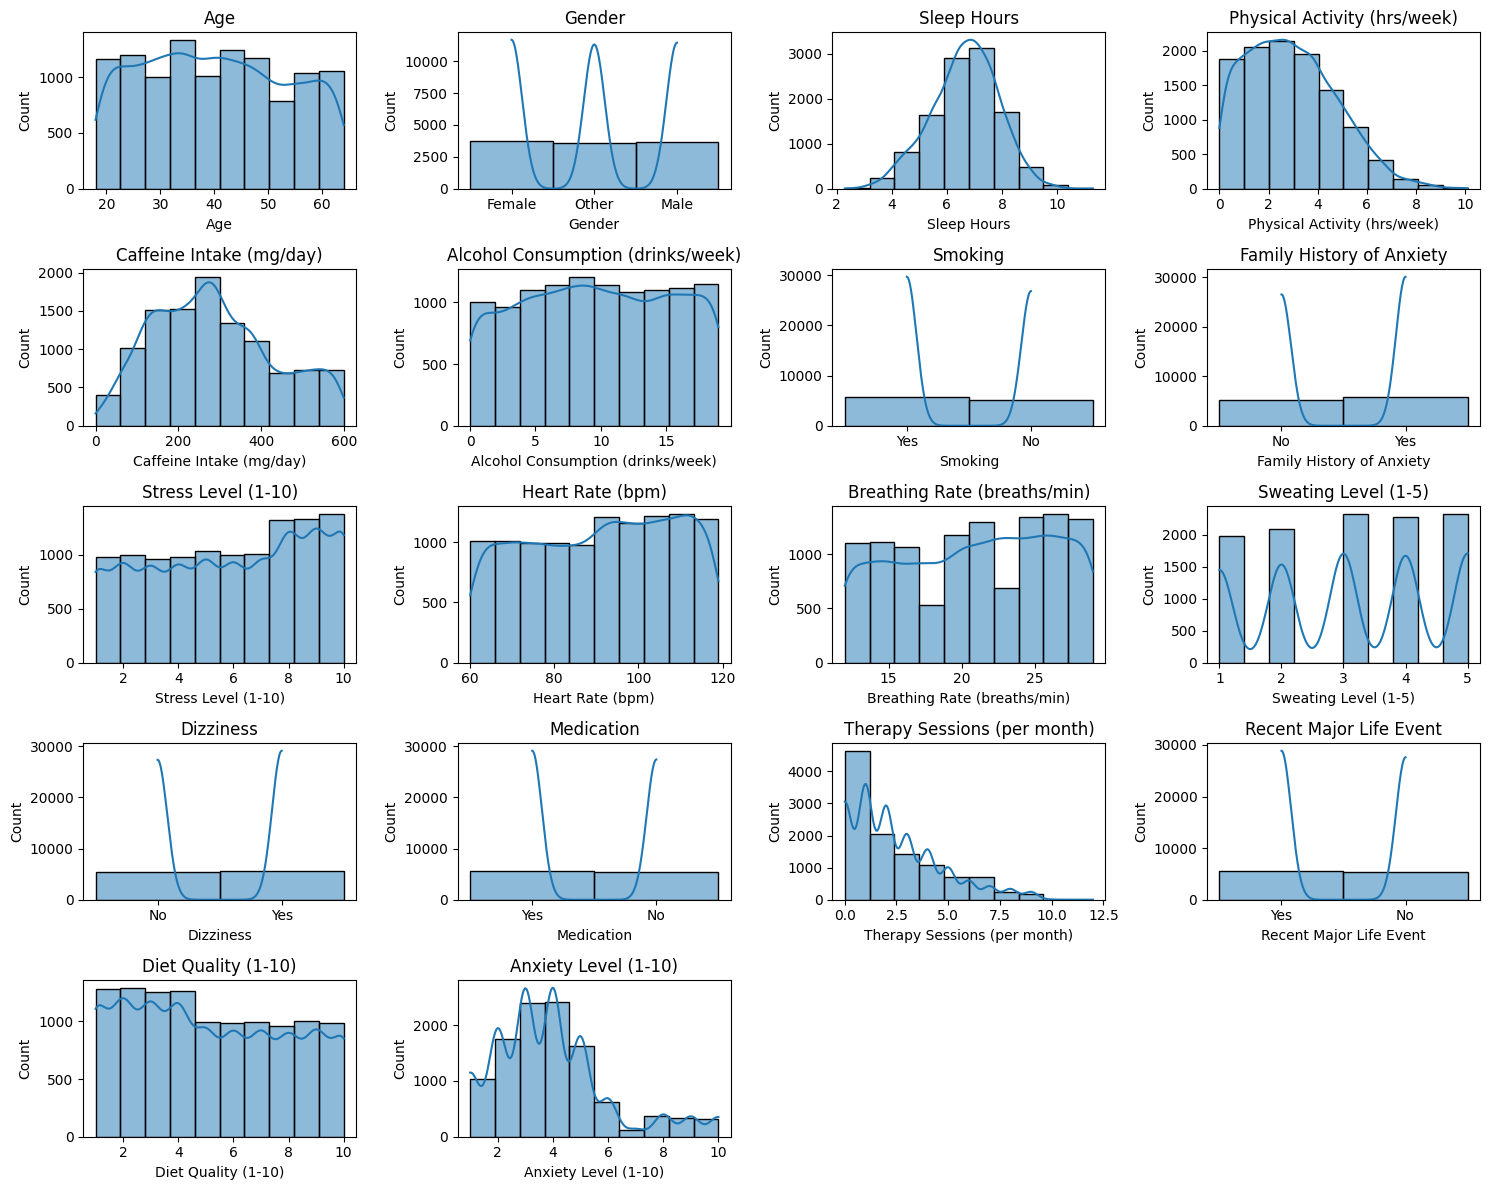

In [4]:
Show_feature_colomns = data1.columns.drop(['Occupation'])
plt.clf()
plt.figure(figsize=(15, 12))
for i, col in enumerate(Show_feature_colomns, 1):
    plt.subplot((len(Show_feature_colomns) // 4) + 1, 4, i)
    sns.histplot(data=data1, x=col, bins=10, kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

/tmp/ipython-input-2335604806.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data1, x='Occupation', order=data1['Occupation'].value_counts().index, palette='viridis')


<Figure size 640x480 with 0 Axes>

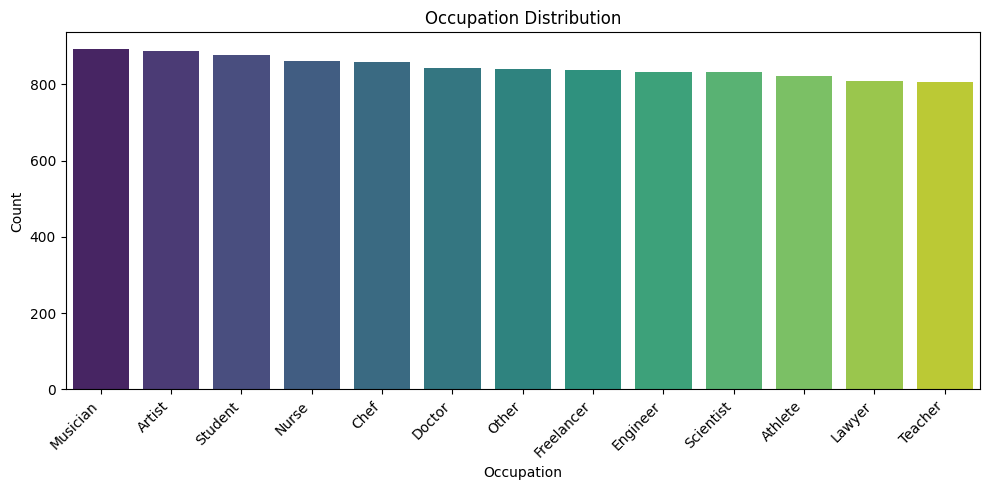

In [5]:
plt.clf()
plt.figure(figsize=(10, 5))
sns.countplot(data=data1, x='Occupation', order=data1['Occupation'].value_counts().index, palette='viridis')

plt.title('Occupation Distribution')
plt.xlabel('Occupation')
plt.ylabel('Count')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Normalization

In [6]:
#normalization
cols_yesorno=["Smoking","Family History of Anxiety","Dizziness","Medication","Recent Major Life Event"]
data1[cols_yesorno] = data1[cols_yesorno].apply(lambda x: x.map({'Yes': 1, 'No': 0}))
cols_gender=["Gender"]
data1[cols_gender] = data1[cols_gender].apply(lambda x: x.map({'Male': 0, 'Female': 1,'Other':2}))
print(data1.head())

   Age  Gender Occupation  Sleep Hours  Physical Activity (hrs/week)  \
0   29       1     Artist          6.0                           2.7   
1   46       2      Nurse          6.2                           5.7   
2   64       0      Other          5.0                           3.7   
3   20       1  Scientist          5.8                           2.8   
4   49       1      Other          8.2                           2.3   

   Caffeine Intake (mg/day)  Alcohol Consumption (drinks/week)  Smoking  \
0                       181                                 10        1   
1                       200                                  8        1   
2                       117                                  4        0   
3                       360                                  6        1   
4                       247                                  4        1   

   Family History of Anxiety  Stress Level (1-10)  Heart Rate (bpm)  \
0                          0                 

Occupation Encoding

In [7]:
#one hot encoding on occupation
data1 = pd.get_dummies(data1, columns=['Occupation'],drop_first=True)
print(data1.head())

   Age  Gender  Sleep Hours  Physical Activity (hrs/week)  \
0   29       1          6.0                           2.7   
1   46       2          6.2                           5.7   
2   64       0          5.0                           3.7   
3   20       1          5.8                           2.8   
4   49       1          8.2                           2.3   

   Caffeine Intake (mg/day)  Alcohol Consumption (drinks/week)  Smoking  \
0                       181                                 10        1   
1                       200                                  8        1   
2                       117                                  4        0   
3                       360                                  6        1   
4                       247                                  4        1   

   Family History of Anxiety  Stress Level (1-10)  Heart Rate (bpm)  ...  \
0                          0                   10               114  ...   
1                          1  

### Step 4: Visual representation of dataset to most realated features

Before building models, creating graphs helps us see potential relationships between anixety and the most affecting features which can increase or reduce the level on aniexty.

<Figure size 640x480 with 0 Axes>

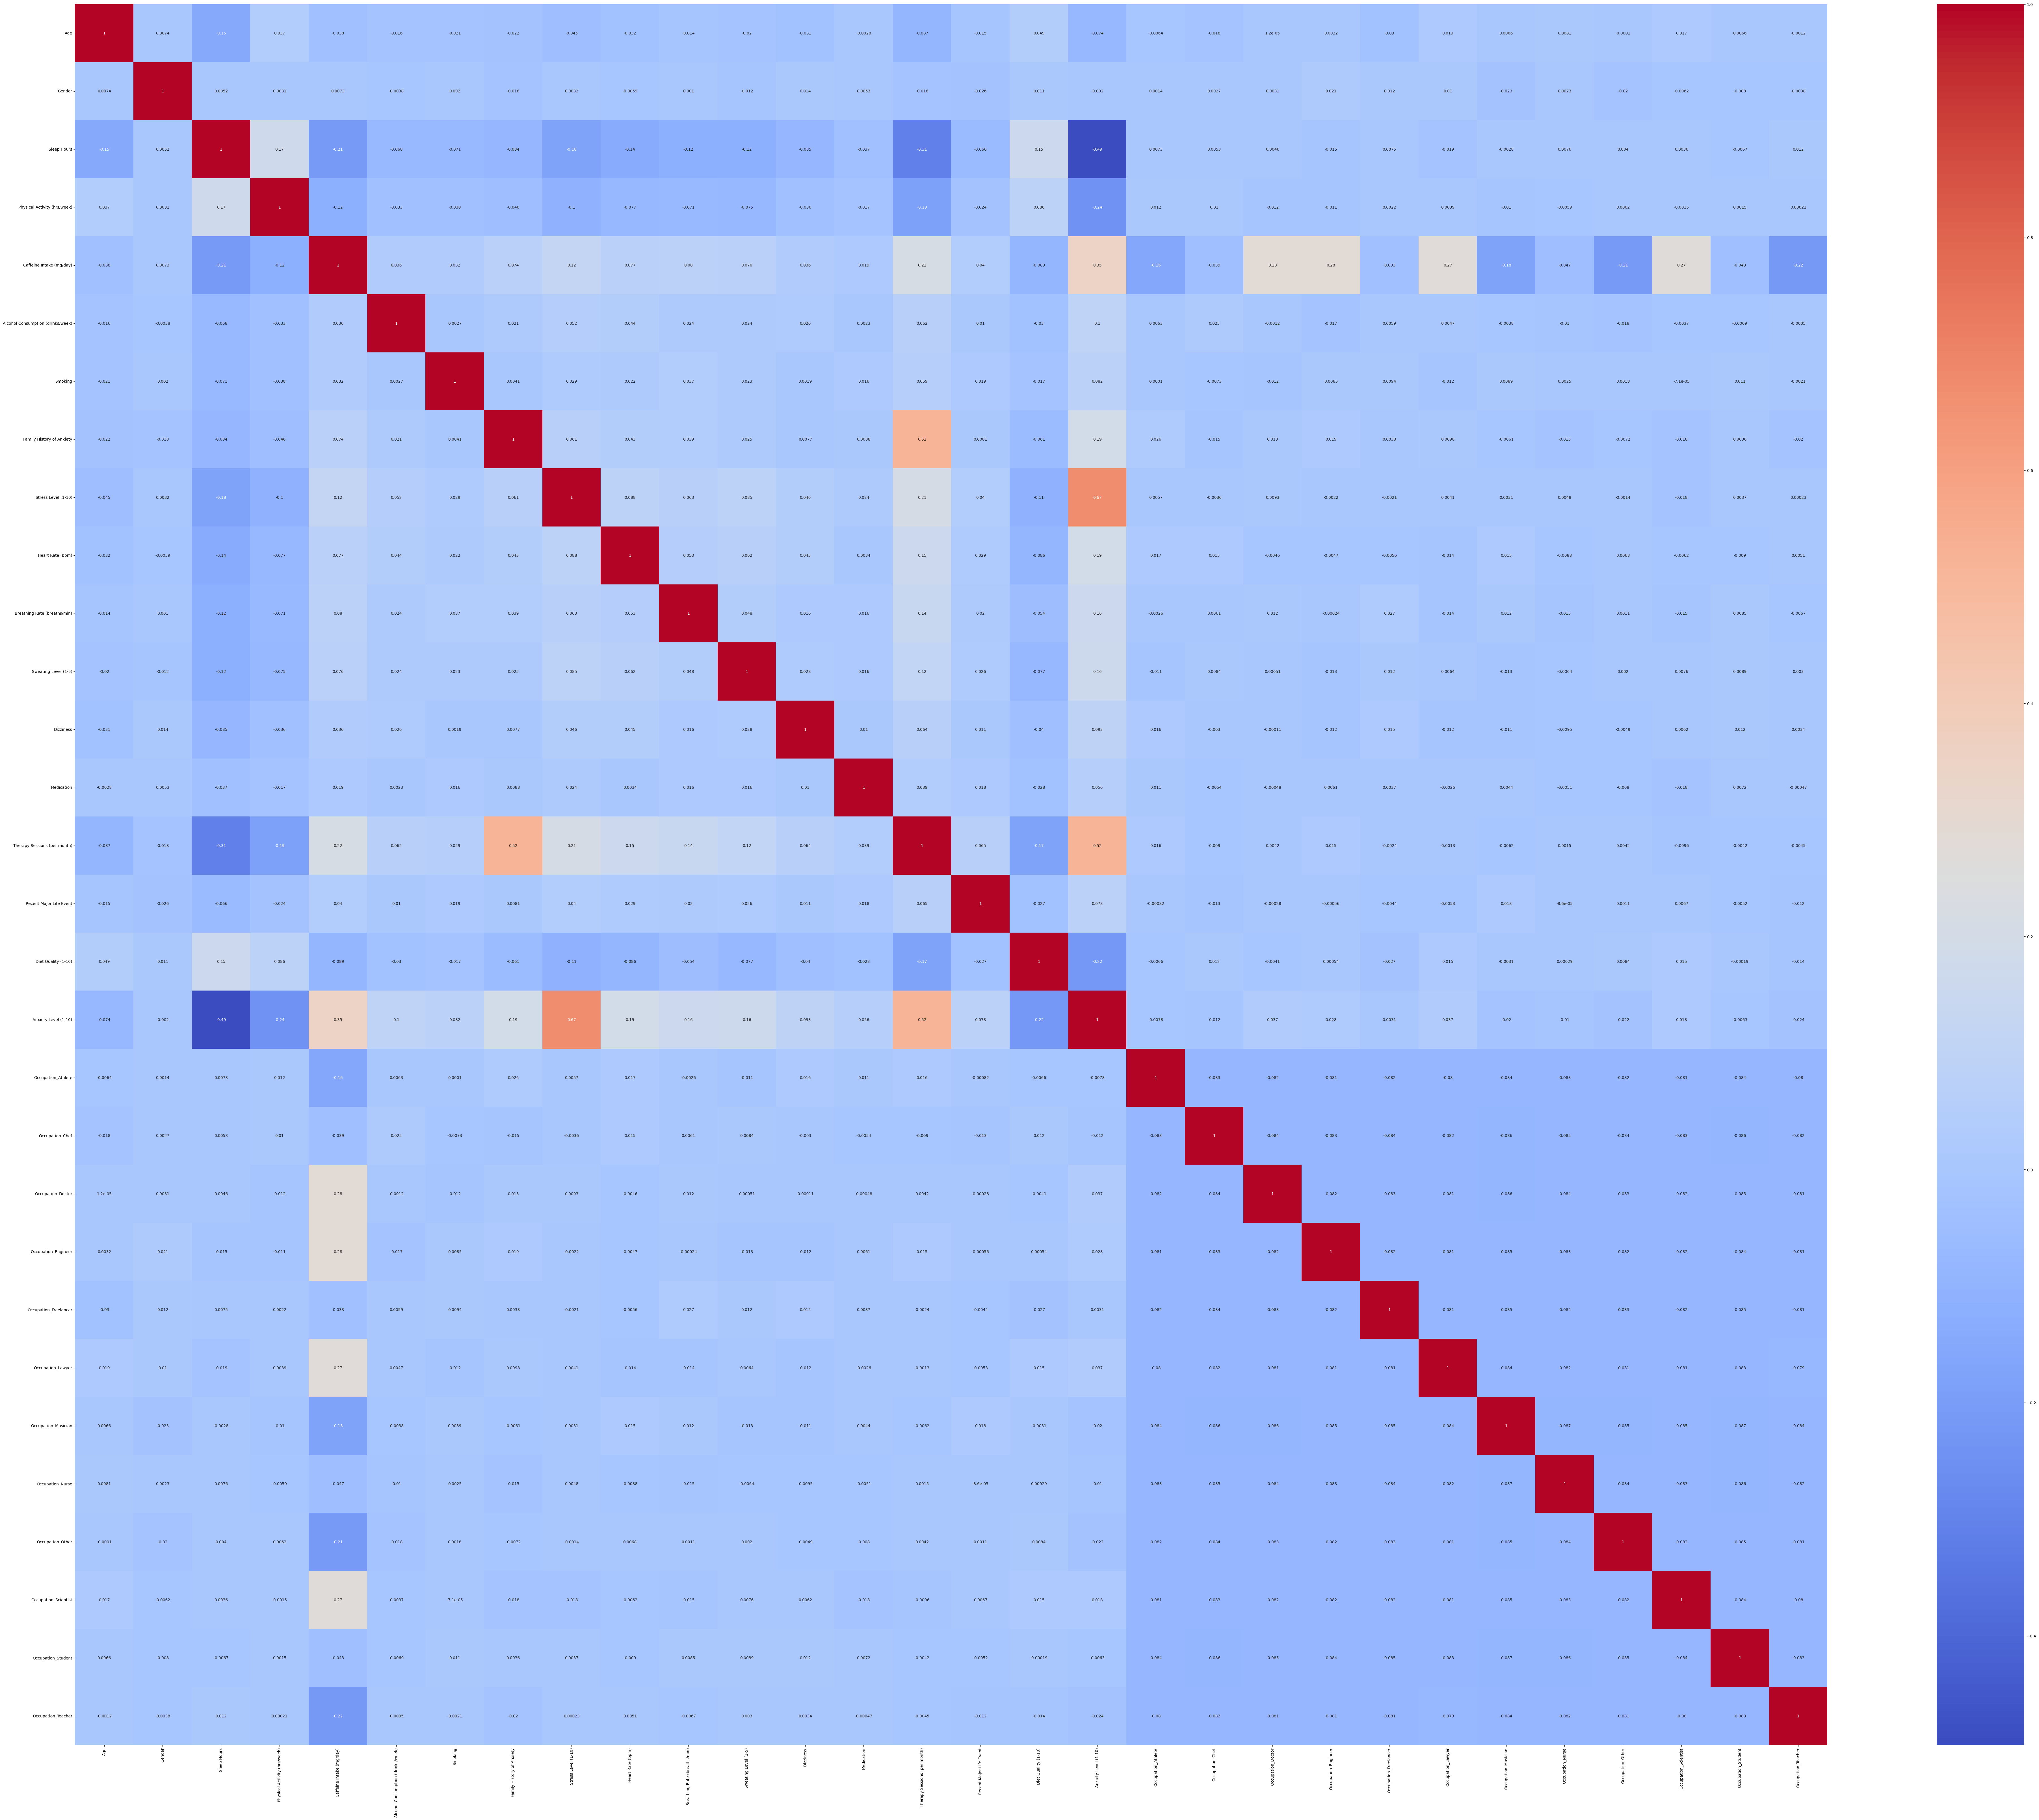

In [8]:

corr_matrix = data1.corr()
plt.clf()
plt.figure(figsize=(100, 80))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [9]:
# choose column start with  Occupation
occupation_cols = [col for col in data1.columns if col.startswith("Occupation_")]

target_col = 'Anxiety Level (1-10)'

occupation_corr = data1[occupation_cols + [target_col]].corr()[target_col]
occupation_corr = occupation_corr.drop(target_col)


print("Correlation between each Occupation_* column and Anxiety Level (1-10):\n")
print(occupation_corr)
# The occupation is not corelated to the target, and there will be too many attributes, so we drop it
data1.drop(columns=occupation_cols, inplace=True)



Correlation between each Occupation_* column and Anxiety Level (1-10):

Occupation_Athlete      -0.007809
Occupation_Chef         -0.012202
Occupation_Doctor        0.036647
Occupation_Engineer      0.028145
Occupation_Freelancer    0.003099
Occupation_Lawyer        0.036780
Occupation_Musician     -0.019613
Occupation_Nurse        -0.010235
Occupation_Other        -0.022364
Occupation_Scientist     0.017943
Occupation_Student      -0.006319
Occupation_Teacher      -0.023820
Name: Anxiety Level (1-10), dtype: float64


Top related features

In [10]:
feature=[]
for i in corr_matrix.columns:
  if corr_matrix[i]['Anxiety Level (1-10)']>0.5 and i!='Anxiety Level (1-10)':
    feature.append(i)
print("Features that correlation Index >0.5")
print(feature)
print("="*50)
target_corr = corr_matrix['Anxiety Level (1-10)'].drop('Anxiety Level (1-10)')
top_features = target_corr.abs().sort_values(ascending=False).head(5)

print("Top 5 most related features:")
print(top_features)

Features that correlation Index >0.5
['Stress Level (1-10)', 'Therapy Sessions (per month)']
Top 5 most related features:
Stress Level (1-10)             0.667939
Therapy Sessions (per month)    0.517606
Sleep Hours                     0.493836
Caffeine Intake (mg/day)        0.350651
Physical Activity (hrs/week)    0.243187
Name: Anxiety Level (1-10), dtype: float64


Correlation Heatmap

Top 5 correlated features: ['Stress Level (1-10)', 'Therapy Sessions (per month)', 'Sleep Hours', 'Caffeine Intake (mg/day)', 'Physical Activity (hrs/week)']


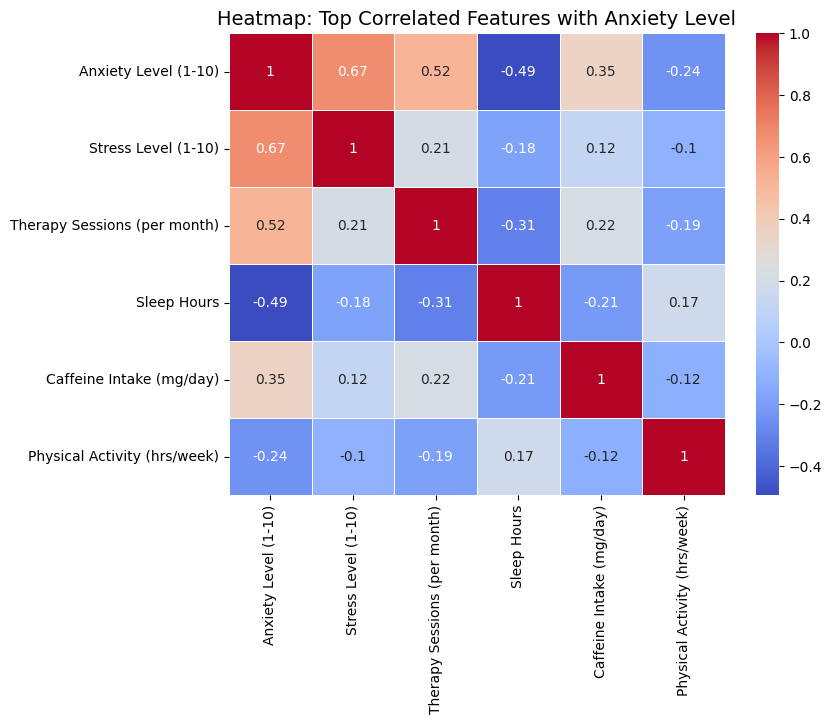

In [11]:
corr_matrix = data1.select_dtypes(include=['number']).corr()
target_corr = corr_matrix['Anxiety Level (1-10)'].drop('Anxiety Level (1-10)')

top_features = target_corr.abs().sort_values(ascending=False).head(5).index.tolist()
print("Top 5 correlated features:", top_features)
selected = ['Anxiety Level (1-10)'] + top_features


subset_corr = corr_matrix.loc[selected, selected]
plt.figure(figsize=(8, 6))
sns.heatmap(subset_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap: Top Correlated Features with Anxiety Level', fontsize=14)
plt.show()


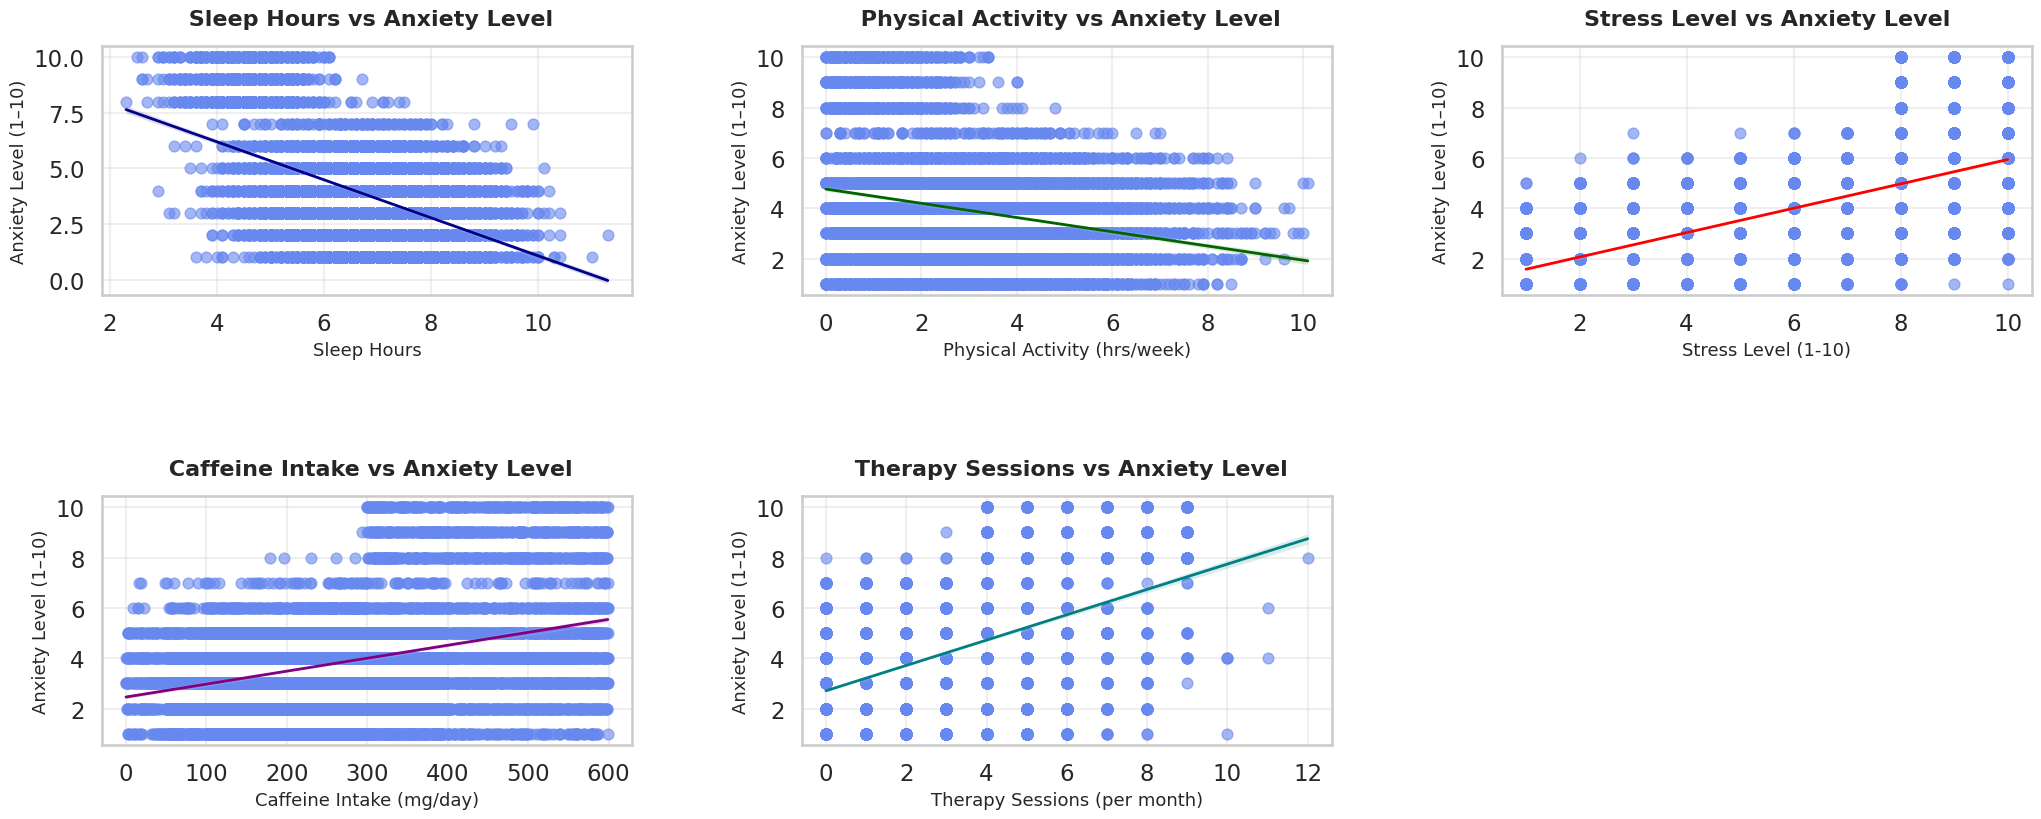

 INSIGHTS FROM THE CHARTS:
• Lower sleep and higher stress levels are associated with higher anxiety.
• Greater physical activity correlates with reduced anxiety.
• Higher caffeine intake tends to elevate anxiety slightly.
• If a feature is statistically important (correlated or predictive) but doesn’t look meaningful in visualization.


In [12]:
#visualsation of highest correlated feature
sns.set_theme(style="whitegrid", context="talk", palette="coolwarm")
fig, axs = plt.subplots(2, 3, figsize=(22, 10))


# Define the charts
charts = [
    ('Sleep Hours', ' Sleep Hours vs Anxiety Level', 'darkblue'),
    ('Physical Activity (hrs/week)', ' Physical Activity vs Anxiety Level', 'darkgreen'),
    ('Stress Level (1-10)', 'Stress Level vs Anxiety Level', 'red'),
    ('Caffeine Intake (mg/day)', ' Caffeine Intake vs Anxiety Level', 'purple'),
    ('Therapy Sessions (per month)', ' Therapy Sessions vs Anxiety Level', 'teal')
]
axs = axs.flatten()

for i, (x, title, color) in enumerate(charts):
    sns.regplot(
        data=data1, x=x, y='Anxiety Level (1-10)', ax=axs[i],
        scatter_kws={'alpha':0.6, 's':60}, line_kws={'color':color, 'lw':2}
    )
    axs[i].set_title(title, fontsize=16, fontweight="bold", pad=15)
    axs[i].set_xlabel(x, fontsize=13)
    axs[i].set_ylabel("Anxiety Level (1–10)", fontsize=13)
    axs[i].grid(alpha=0.3)


axs[-1].axis('off')
plt.tight_layout(pad=4)
plt.show()
print(" INSIGHTS FROM THE CHARTS:")
print("• Lower sleep and higher stress levels are associated with higher anxiety.")
print("• Greater physical activity correlates with reduced anxiety.")
print("• Higher caffeine intake tends to elevate anxiety slightly.")
print("• If a feature is statistically important (correlated or predictive) but doesn’t look meaningful in visualization.")

Even if our model says "Therapy Sessions" is one of the top predictors, the plot may look unclear because:

1.Indirect Effect – Therapy sessions might not directly reduce anxiety but act through other features (e.g., stress, sleep, medication).

2.Nonlinear Relationship – The effect may not be a straight line (e.g., anxiety should decreases after a threshold number of sessions).

3.Noise and Individual Variability – People respond differently to therapy; high variance hides the visual trend.

# **Feature Engineering**

# Step 1: Feature combination - creating new features

In [13]:

data1['Therapy_LifeEvent_Interaction'] = data1['Therapy Sessions (per month)'] * data1['Recent Major Life Event']
data1['Therapy_Stress_Interaction'] = data1['Therapy Sessions (per month)'] * data1['Stress Level (1-10)']
data1['Therapy_Activity_Ratio'] = data1['Therapy Sessions (per month)'] / (data1['Physical Activity (hrs/week)'] + 1)
data1['Therapy_Diet_Interaction'] = data1['Therapy Sessions (per month)'] / (data1['Diet Quality (1-10)'] + 1)

corrs = data1.corr(numeric_only=True)['Anxiety Level (1-10)'].sort_values(ascending=False)
print(corrs)


Anxiety Level (1-10)                 1.000000
Therapy_Stress_Interaction           0.724045
Stress Level (1-10)                  0.667939
Therapy_Activity_Ratio               0.572086
Therapy_Diet_Interaction             0.544339
Therapy Sessions (per month)         0.517606
Therapy_LifeEvent_Interaction        0.399168
Caffeine Intake (mg/day)             0.350651
Family History of Anxiety            0.190900
Heart Rate (bpm)                     0.188900
Sweating Level (1-5)                 0.160074
Breathing Rate (breaths/min)         0.157048
Alcohol Consumption (drinks/week)    0.100626
Dizziness                            0.093047
Smoking                              0.081847
Recent Major Life Event              0.078248
Medication                           0.056498
Gender                              -0.002008
Age                                 -0.074316
Diet Quality (1-10)                 -0.220245
Physical Activity (hrs/week)        -0.243187
Sleep Hours                       

Therapy_Stress_Interaction → likely positive correlation higher stress = more therapy = higher anxiety. This suggests therapy may interact with other lifestyle variables or exhibit nonlinear effects, warranting further investigation.

   Heart Rate (bpm)  Breathing Rate (breaths/min)  Physio_Score
0          0.915254                      0.117647      0.134596
1          0.033898                      0.647059      0.027418
2          0.525424                      0.941176      0.618146
3          0.440678                      0.294118      0.162014
4          0.644068                      0.411765      0.331505


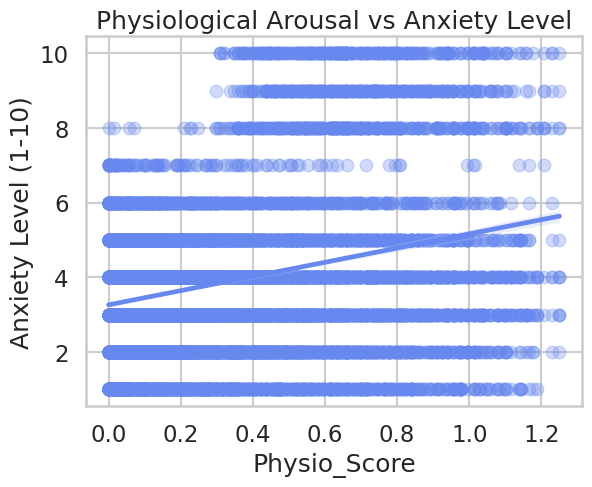

Correlation: 0.2709467168654673


In [14]:
data1 = data1.drop(columns=['Therapy Sessions (per month)'])
from sklearn.preprocessing import MinMaxScaler
# Select physiological features
physio_cols = ['Heart Rate (bpm)', 'Breathing Rate (breaths/min)']

# Normalize between 0 and 1
scaler = MinMaxScaler()
data1[physio_cols] = scaler.fit_transform(data1[physio_cols])


data1['Physio_Score'] =  0.5*data1['Heart Rate (bpm)'] / 0.4*data1['Breathing Rate (breaths/min)']
print(data1[['Heart Rate (bpm)', 'Breathing Rate (breaths/min)', 'Physio_Score']].head())
sns.regplot(data=data1, x='Physio_Score', y='Anxiety Level (1-10)', scatter_kws={'alpha':0.3})
plt.title('Physiological Arousal vs Anxiety Level')
plt.show()
print("Correlation:", data1['Physio_Score'].corr(data1['Anxiety Level (1-10)']))

In [15]:
correlated_value1 = data1['Physio_Score'].corr(data1['Heart Rate (bpm)'])
correlated_value2 = data1['Physio_Score'].corr(data1['Breathing Rate (breaths/min)'])

print(f"Correlation between Physio_Score and Heart Rate (bpm): {correlated_value1:.4f}")
print(f"Correlation between Physio_Score and Breathing Rate (breaths/min): {correlated_value2:.4f}")

correlations = {
    'Heart Rate (bpm)': correlated_value1,
    'Breathing Rate (breaths/min)': correlated_value2
}

columns_to_drop = []

for column_name, corr_value in correlations.items():
    if corr_value > 0.8:
        print(f"This feature '{column_name}' is strongly related to Physio_Score (r = {corr_value:.4f}). Drop it.")
        columns_to_drop.append(column_name)
    else:
        print(f"This feature '{column_name}' is not strongly related to Physio_Score (r = {corr_value:.4f}). Keep it.")

if columns_to_drop:
    data1.drop(columns=columns_to_drop, inplace=True)
    print(f"Dropped columns: {columns_to_drop}")

Correlation between Physio_Score and Heart Rate (bpm): 0.6720
Correlation between Physio_Score and Breathing Rate (breaths/min): 0.6772
This feature 'Heart Rate (bpm)' is not strongly related to Physio_Score (r = 0.6720). Keep it.
This feature 'Breathing Rate (breaths/min)' is not strongly related to Physio_Score (r = 0.6772). Keep it.


   Heart Rate (bpm)  Sweating Level (1-5)  Tension_Index
0          0.915254                     4       0.686441
1          0.033898                     2       0.008475
2          0.525424                     3       0.262712
3          0.440678                     3       0.220339
4          0.644068                     4       0.483051


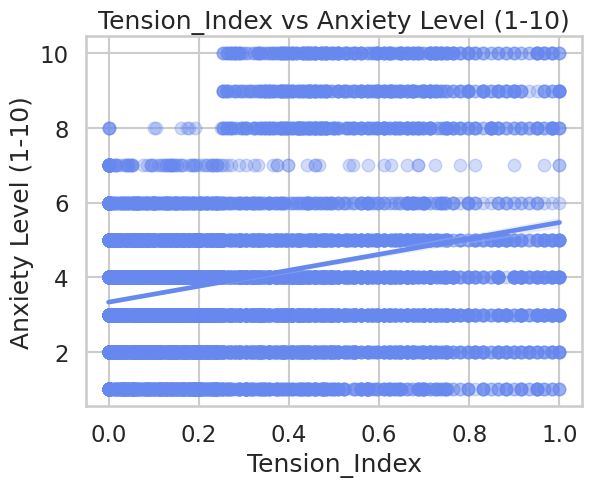

Correlation between Tension_Index and Anxiety Level: 0.2670


In [16]:
heart_col = 'Heart Rate (bpm)'
sweat_col = 'Sweating Level (1-5)'
scaler = MinMaxScaler()
data1[['Heart_Norm', 'Sweat_Norm']] = scaler.fit_transform(data1[[heart_col, sweat_col]])


data1['Tension_Index'] = data1['Heart_Norm'] * data1['Sweat_Norm']
data1.drop(columns=['Heart_Norm', 'Sweat_Norm'], inplace=True)


print(data1[[heart_col, sweat_col, 'Tension_Index']].head())
sns.regplot(
    data=data1,
    x='Tension_Index',
    y='Anxiety Level (1-10)',
    scatter_kws={'alpha': 0.3}
)
plt.title("Tension_Index vs Anxiety Level (1-10)")
plt.xlabel("Tension_Index")
plt.ylabel("Anxiety Level (1-10)")
plt.show()

corr_value = data1['Tension_Index'].corr(data1['Anxiety Level (1-10)'])
print(f"Correlation between Tension_Index and Anxiety Level: {corr_value:.4f}")

if abs(corr_value) < 0.2:
    print("="*50)
    print("This new feature is not strongly related to anxiety level. Dropping it...")
    data1.drop(columns=['Tension_Index'], inplace=True)

In [17]:
correlated_value1 = data1['Tension_Index'].corr(data1['Heart Rate (bpm)'])
correlated_value2 = data1['Tension_Index'].corr(data1['Sweating Level (1-5)'])

print(f"Correlation between Tension_Index and Heart Rate (bpm): {correlated_value1:.4f}")
print(f"Correlation between Tension_Index and 'Sweating Level (1-5)': {correlated_value2:.4f}")

correlations = {
    'Heart Rate (bpm)': correlated_value1,
    'Sweating Level (1-5)': correlated_value2
}

columns_to_drop = []

for column_name, corr_value in correlations.items():
    if corr_value > 0.8:
        print(f"This feature '{column_name}' is strongly related to Tension_Index (r = {corr_value:.4f}). Drop it.")
        columns_to_drop.append(column_name)
    else:
        print(f"This feature '{column_name}' is not strongly related to Tension_Index (r = {corr_value:.4f}). Keep it.")

if columns_to_drop:
    data1.drop(columns=columns_to_drop, inplace=True)
    print(f"Dropped columns: {columns_to_drop}")

Correlation between Tension_Index and Heart Rate (bpm): 0.6184
Correlation between Tension_Index and 'Sweating Level (1-5)': 0.7214
This feature 'Heart Rate (bpm)' is not strongly related to Tension_Index (r = 0.6184). Keep it.
This feature 'Sweating Level (1-5)' is not strongly related to Tension_Index (r = 0.7214). Keep it.


   Sleep Hours  Caffeine Intake (mg/day)  Sleep_Caffeine_Balance
0          6.0                       181                1.356040
1          6.2                       200                1.293958
2          5.0                       117                1.528074
3          5.8                       360                0.645993
4          8.2                       247                1.585943


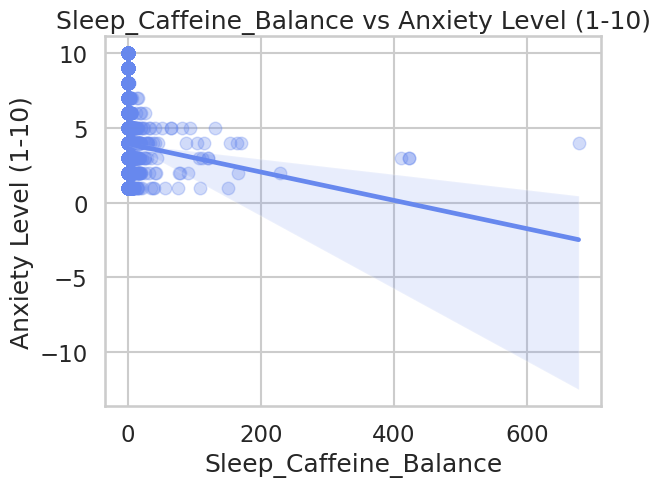

Correlation between Sleep_Caffeine_Balance and Anxiety Level: -0.0501
This new feature is not strongly related to anxiety level. Dropping it.


In [18]:
sleep_col = 'Sleep Hours'
caffeine_col = 'Caffeine Intake (mg/day)'

# Normalize between 0 and 1
scaler = MinMaxScaler()
data1[['Sleep_Norm', 'Caffeine_Norm']] = scaler.fit_transform(data1[[sleep_col, caffeine_col]])

data1['Sleep_Caffeine_Balance'] = data1['Sleep_Norm'] / (data1['Caffeine_Norm'] + 1e-3)

print(data1[[sleep_col, caffeine_col, 'Sleep_Caffeine_Balance']].head())
data1.drop(columns=['Sleep_Norm', 'Caffeine_Norm'], inplace=True)

sns.regplot(
    data=data1,
    x='Sleep_Caffeine_Balance',
    y='Anxiety Level (1-10)',
    scatter_kws={'alpha': 0.3}
)
plt.title("Sleep_Caffeine_Balance vs Anxiety Level (1-10)")
plt.xlabel("Sleep_Caffeine_Balance")
plt.ylabel("Anxiety Level (1-10)")
plt.show()

corr_value = data1['Sleep_Caffeine_Balance'].corr(data1['Anxiety Level (1-10)'])
print(f"Correlation between Sleep_Caffeine_Balance and Anxiety Level: {corr_value:.4f}")


if abs(corr_value) < 0.2:
    print("="*50)
    print("This new feature is not strongly related to anxiety level. Dropping it.")
    data1.drop(columns=['Sleep_Caffeine_Balance'], inplace=True)


   Sleep Hours  Caffeine Intake (mg/day)  Sleep_Alcohol_Balance
0          6.0                       181               0.779630
1          6.2                       200               1.026728
2          5.0                       117               1.418263
3          5.8                       360               1.227594
4          8.2                       247               3.099168


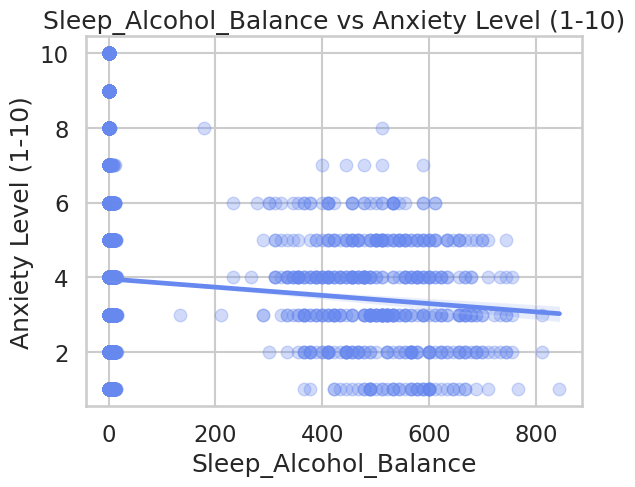

Correlation between Sleep_Alcohol_Balance and Anxiety Level: -0.0567
This new feature is not strongly related to anxiety level. Drop it.


In [19]:
sleep_col = 'Sleep Hours'
alcohol_col = 'Alcohol Consumption (drinks/week)'
scaler = MinMaxScaler()
data1[['Sleep_Norm', 'Alcohol_Norm']] = scaler.fit_transform(data1[[sleep_col, alcohol_col]])

data1['Sleep_Alcohol_Balance'] = data1['Sleep_Norm'] / (data1['Alcohol_Norm'] + 1e-3)

print(data1[[sleep_col, caffeine_col, 'Sleep_Alcohol_Balance']].head())
data1.drop(columns=['Sleep_Norm', 'Alcohol_Norm'], inplace=True)

sns.regplot(
    data=data1,
    x='Sleep_Alcohol_Balance',
    y='Anxiety Level (1-10)',
    scatter_kws={'alpha': 0.3}
)
plt.title("Sleep_Alcohol_Balance vs Anxiety Level (1-10)")
plt.xlabel("Sleep_Alcohol_Balance")
plt.ylabel("Anxiety Level (1-10)")
plt.show()

corr_value = data1['Sleep_Alcohol_Balance'].corr(data1['Anxiety Level (1-10)'])
print(f"Correlation between Sleep_Alcohol_Balance and Anxiety Level: {corr_value:.4f}")


if abs(corr_value) < 0.2:
    print("="*50)
    print("This new feature is not strongly related to anxiety level. Drop it.")
    data1.drop(columns=['Sleep_Alcohol_Balance'], inplace=True)

   Sleep Hours  Stress Level (1-10)  Sleep_Stress_Ratio
0     0.411111             1.000000            0.411111
1     0.433333             0.001000          433.333333
2     0.300000             0.001000          300.000000
3     0.388889             0.333333            1.166667
4     0.655556             0.001000          655.555556


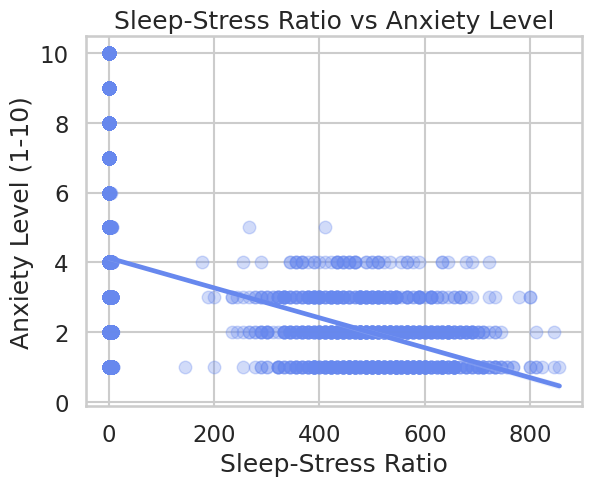

Correlation: -0.2984866474926894


In [20]:
stress_sleep_cols = ['Sleep Hours', 'Stress Level (1-10)']
scaler = MinMaxScaler()
data1[stress_sleep_cols] = scaler.fit_transform(data1[stress_sleep_cols])

epsilon = 1e-6
data1['Stress Level (1-10)'] = data1['Stress Level (1-10)'].replace(0, 1e-3)

data1['Sleep_Stress_Ratio'] = data1['Sleep Hours'] / data1['Stress Level (1-10)']

print(data1[['Sleep Hours', 'Stress Level (1-10)', 'Sleep_Stress_Ratio']].head())

sns.regplot(
    data=data1,
    x='Sleep_Stress_Ratio',
    y='Anxiety Level (1-10)',
    scatter_kws={'alpha': 0.3}
)
plt.title('Sleep-Stress Ratio vs Anxiety Level')
plt.xlabel('Sleep-Stress Ratio')
plt.ylabel('Anxiety Level (1-10)')
plt.show()

print("Correlation:", data1['Sleep_Stress_Ratio'].corr(data1['Anxiety Level (1-10)']))


   Physical Activity (hrs/week)  Stress Level (1-10)  Stress_Control_Score
0                      0.267327             1.000000              0.267327
1                      0.564356             0.001000            564.356436
2                      0.366337             0.001000            366.336634
3                      0.277228             0.332666              0.833352
4                      0.227723             0.001000            227.722772


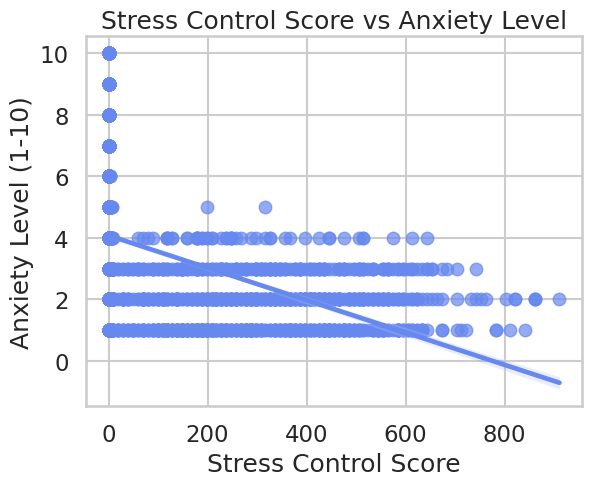

Correlation: -0.2553924050939939


In [21]:
stress_control_cols = ['Physical Activity (hrs/week)', 'Stress Level (1-10)']


scaler = MinMaxScaler()
data1[stress_control_cols] = scaler.fit_transform(data1[stress_control_cols])

data1['Stress Level (1-10)'] = data1['Stress Level (1-10)'].replace(0, 1e-3)
data1['Stress_Control_Score'] = data1['Physical Activity (hrs/week)'] / data1['Stress Level (1-10)']
print(data1[['Physical Activity (hrs/week)', 'Stress Level (1-10)', 'Stress_Control_Score']].head())



sns.regplot(
    data=data1,
    x='Stress_Control_Score',
    y='Anxiety Level (1-10)',
    scatter_kws={'alpha': 0.7}
)
plt.title('Stress Control Score vs Anxiety Level')
plt.xlabel('Stress Control Score')
plt.ylabel('Anxiety Level (1-10)')
plt.show()

print("Correlation:", data1['Stress_Control_Score'].corr(data1['Anxiety Level (1-10)']))


Correlation Matrix

<Figure size 640x480 with 0 Axes>

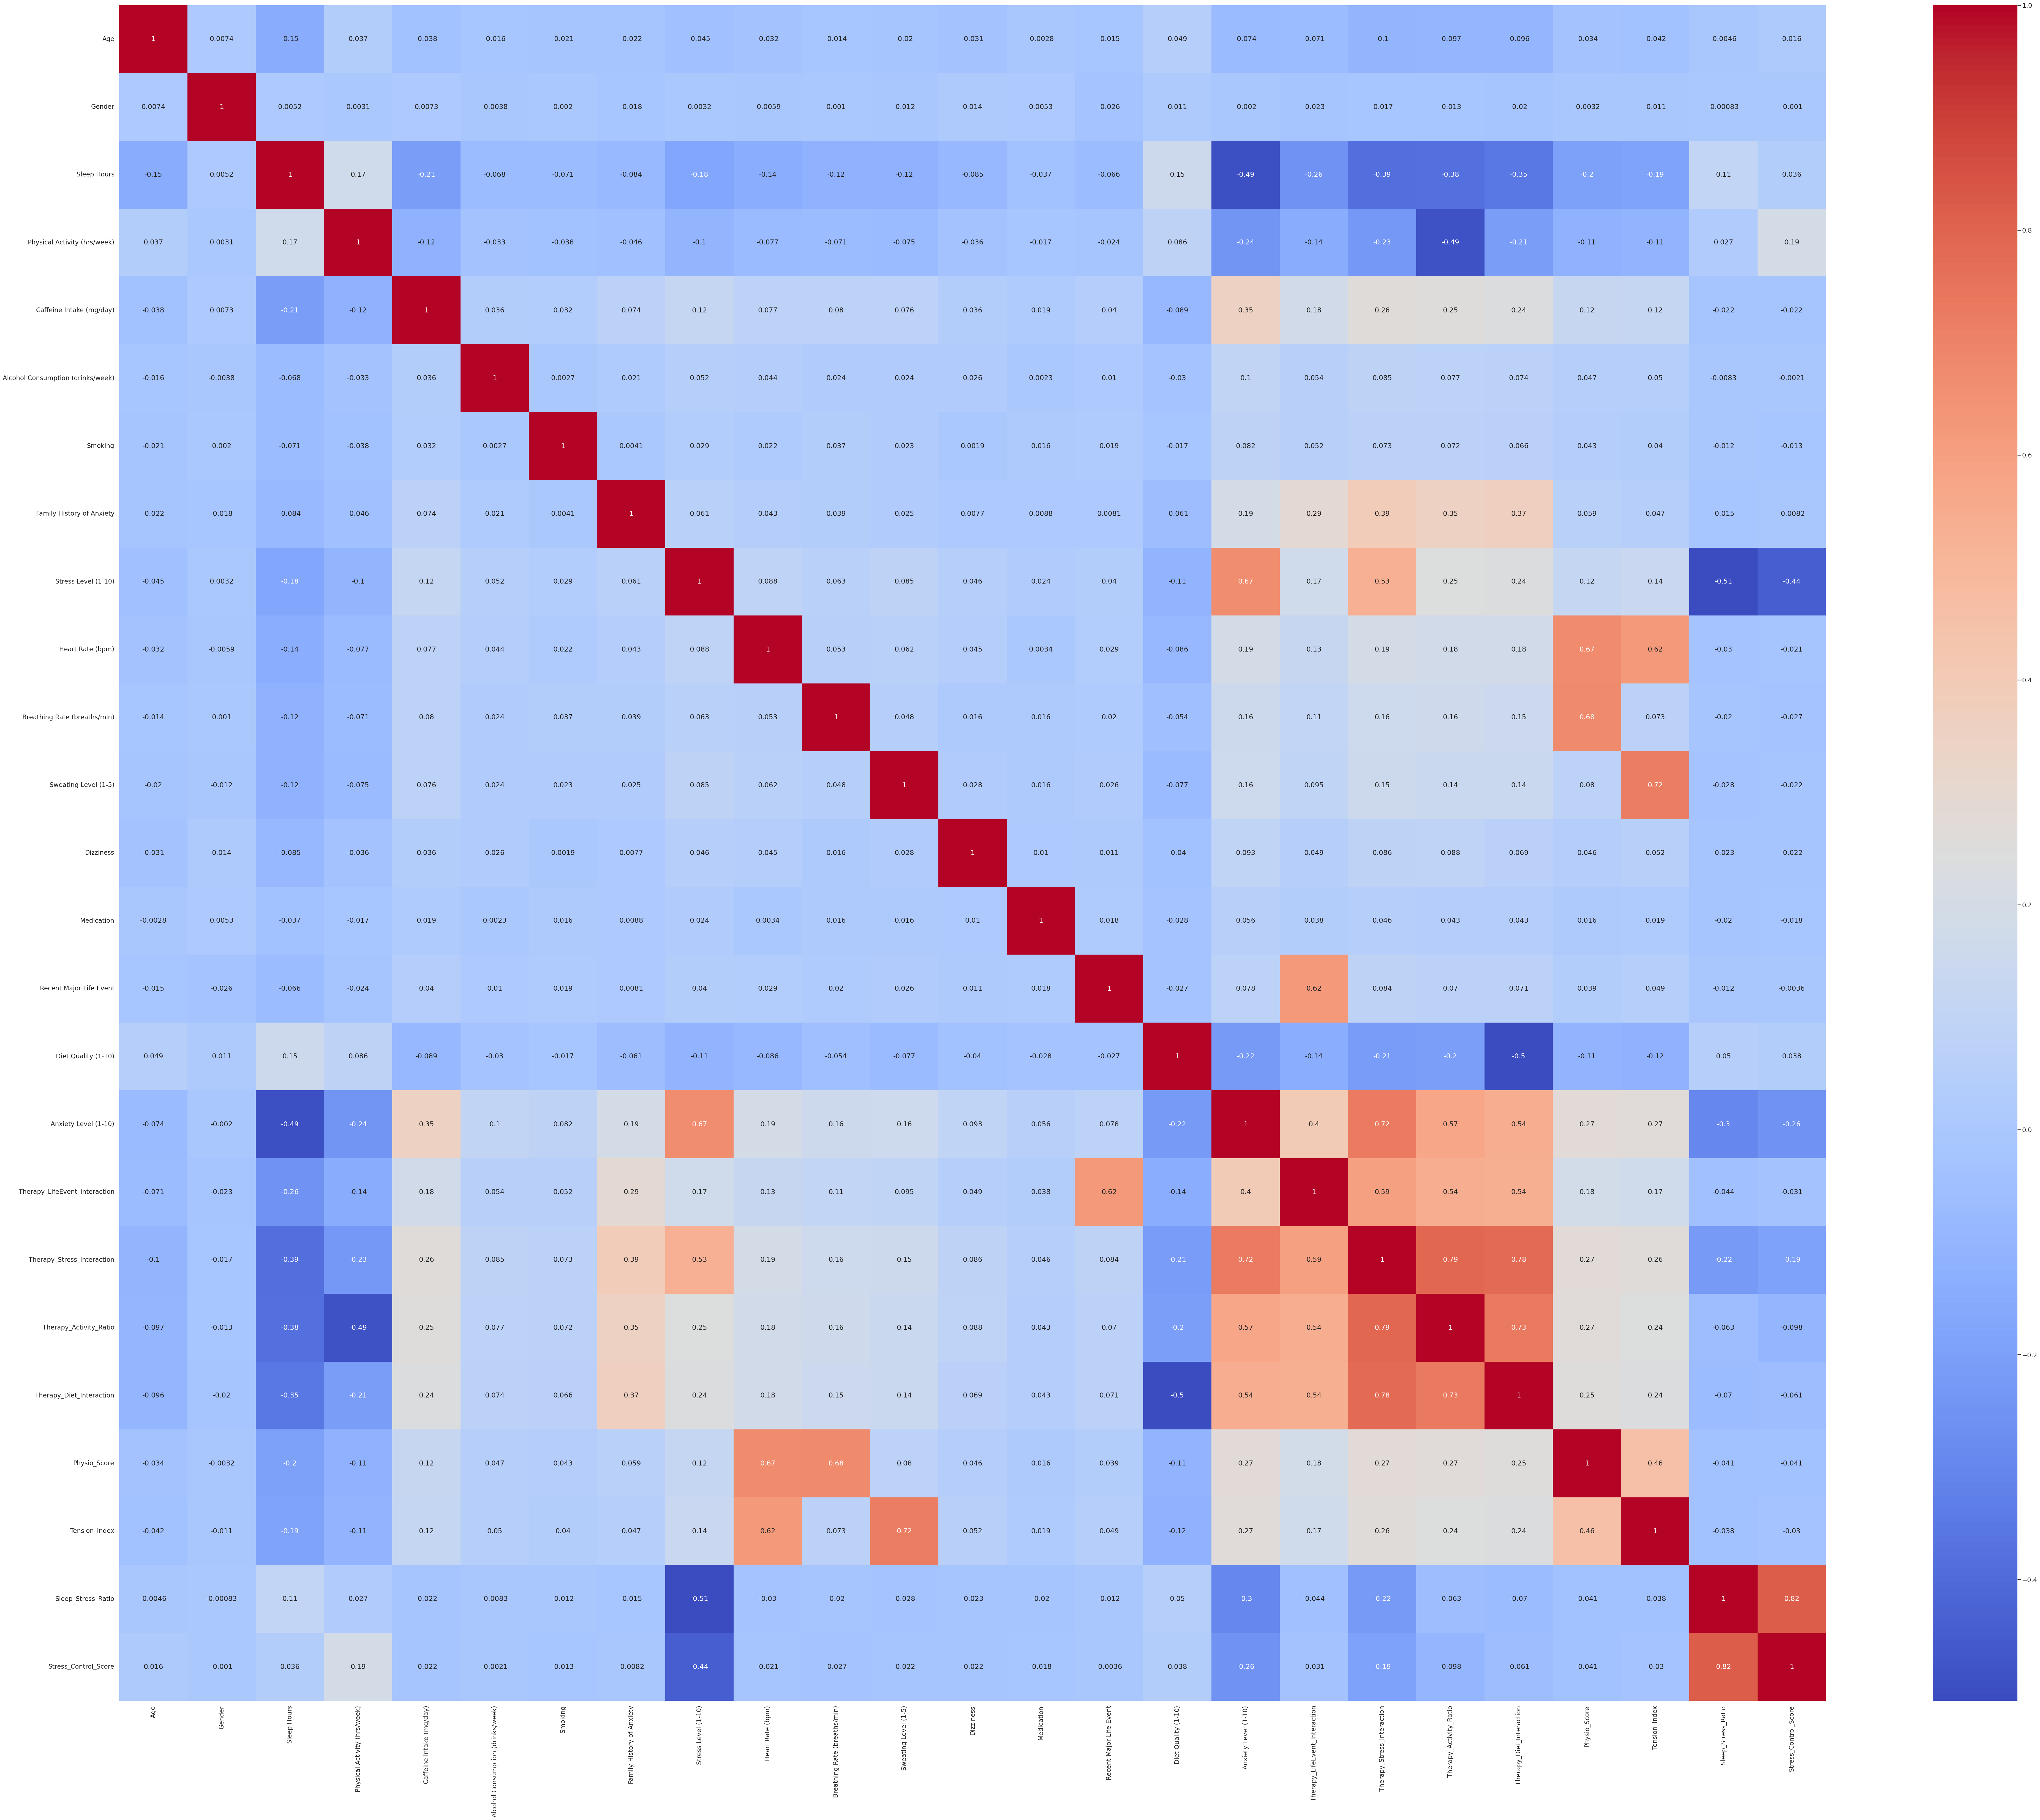

(11000, 25)
Anxiety Level (1-10)                 1.000000
Therapy_Stress_Interaction           0.724045
Stress Level (1-10)                  0.668025
Therapy_Activity_Ratio               0.572086
Therapy_Diet_Interaction             0.544339
Therapy_LifeEvent_Interaction        0.399168
Caffeine Intake (mg/day)             0.350651
Physio_Score                         0.270947
Tension_Index                        0.266999
Family History of Anxiety            0.190900
Heart Rate (bpm)                     0.188900
Sweating Level (1-5)                 0.160074
Breathing Rate (breaths/min)         0.157048
Alcohol Consumption (drinks/week)    0.100626
Dizziness                            0.093047
Smoking                              0.081847
Recent Major Life Event              0.078248
Medication                           0.056498
Gender                              -0.002008
Age                                 -0.074316
Diet Quality (1-10)                 -0.220245
Physical Activity (hrs

In [22]:
corr_matrix = data1.corr(numeric_only=True)
plt.clf()
plt.figure(figsize=(100, 80))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()
print(data1.shape)


corrs = data1.corr(numeric_only=True)['Anxiety Level (1-10)'].sort_values(ascending=False)
print(corrs)

# Step 2: Split Data into Training and Testing Sets

 We'll use 80% of the data to "train" our model and the remaining 20% to "test" how well it performs on new, unseen data.

In [23]:

y = data1['Anxiety Level (1-10)']


X = data1.drop(columns=['Anxiety Level (1-10)'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (8800, 24)
Shape of X_test: (2200, 24)
Shape of y_train: (8800,)
Shape of y_test: (2200,)


# Step 3: Scale the Features

In [24]:
X_train = X_train.select_dtypes(include=['number'])
X_test = X_test.select_dtypes(include=['number'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("First 5 rows of scaled training data:")
print(X_train_scaled[:5])

First 5 rows of scaled training data:
[[-0.01908239  0.00446535  0.20143234 -1.39618932  0.07945558 -1.36274381
   0.94341633  0.94169658 -0.97381025 -0.98215366  0.19742074  0.67042375
  -1.0349278  -1.0335159  -1.02345686  0.28290424 -0.62996812 -0.1843384
   1.69826194  0.01232767 -0.58843568 -0.37406078 -0.29547922 -0.27123018]
 [-0.77210924  0.00446535 -1.10930219 -0.24372603  0.93121218  0.39677047
   0.94341633  0.94169658  0.73770234  0.807385    0.00352537  1.38424455
   0.96625098 -1.0335159   0.97708076 -0.75326002  2.2659327   1.71745616
   0.71854155  1.28841519  0.50189728  1.8292103  -0.30825701 -0.2698748 ]
 [-0.69680655 -1.22350541 -1.43698582 -1.34131012  1.70679543 -0.6589381
  -1.05997742  0.94169658  1.42230738  1.5578367   0.77910686  0.67042375
   0.96625098 -1.0335159   0.97708076 -1.44403619  1.30063243  1.29483514
   1.53497521  1.97553923  1.93784521  1.7334159  -0.30921074 -0.27248691]
 [ 1.48697132 -1.22350541 -0.69969765 -1.50594773 -0.48145731  1.45247904

# **Model Evaluation**

## **Regression models**

## 1.Linear Regression


Linear Regression Results:
MSE: 1.183677463748939
RMSE: 1.0879694222490532
R²: 0.7445490746537138
MAE: 0.8647799188371528


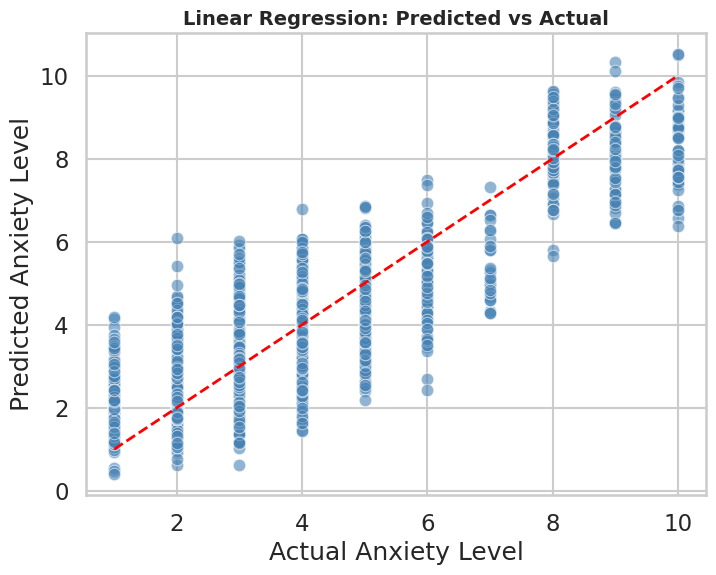

/tmp/ipython-input-389774003.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')


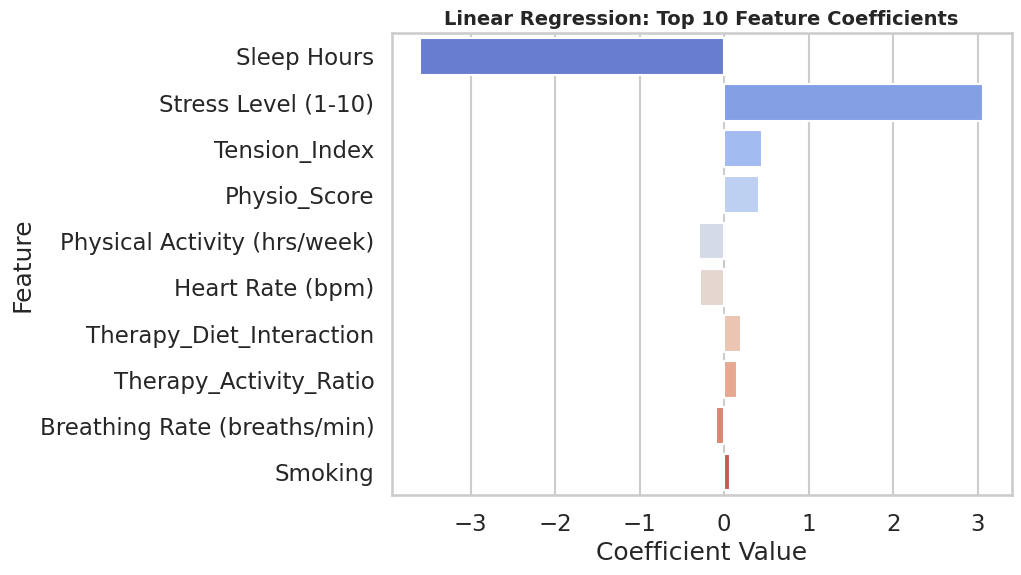

In [25]:
from sklearn.linear_model import LinearRegression


lr_model = LinearRegression()

X_train_numeric = X_train.select_dtypes(include=['number'])
X_test_numeric = X_test.select_dtypes(include=['number'])
lr_model.fit(X_train_numeric, y_train)

y_pred_lr = lr_model.predict(X_test_numeric)


mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lr)
mae = mean_absolute_error(y_test, y_pred_lr)


print("Linear Regression Results:")
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)
print("MAE:", mae)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.6, color='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Anxiety Level')
plt.ylabel('Predicted Anxiety Level')
plt.title('Linear Regression: Predicted vs Actual', fontsize=14, fontweight='bold')
plt.show()


coef_df = pd.DataFrame({'Feature': X_train_numeric.columns, 'Coefficient': lr_model.coef_})
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')
plt.title('Linear Regression: Top 10 Feature Coefficients', fontsize=14, fontweight='bold')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

## 2.Random Forest

Random Forest Results:
MSE: 1.0291477727272729
RMSE: 1.0144692073824977
R²: 0.777898322040697
MAE: 0.8179318181818181


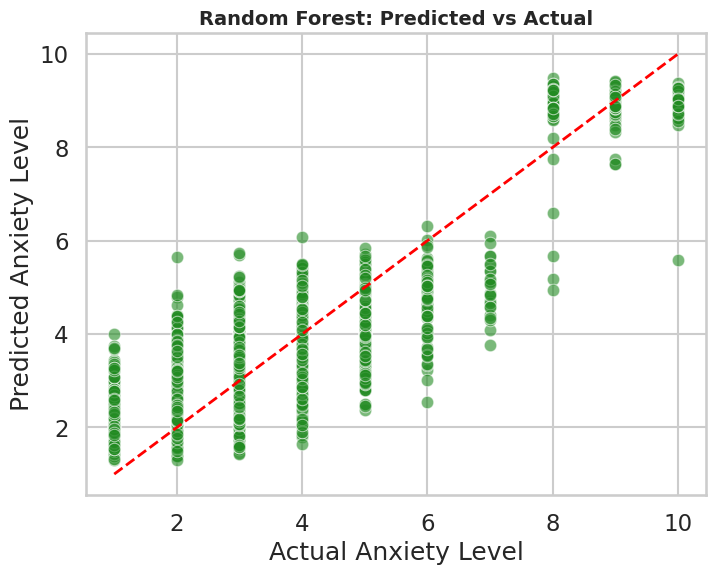

/tmp/ipython-input-2548510527.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')


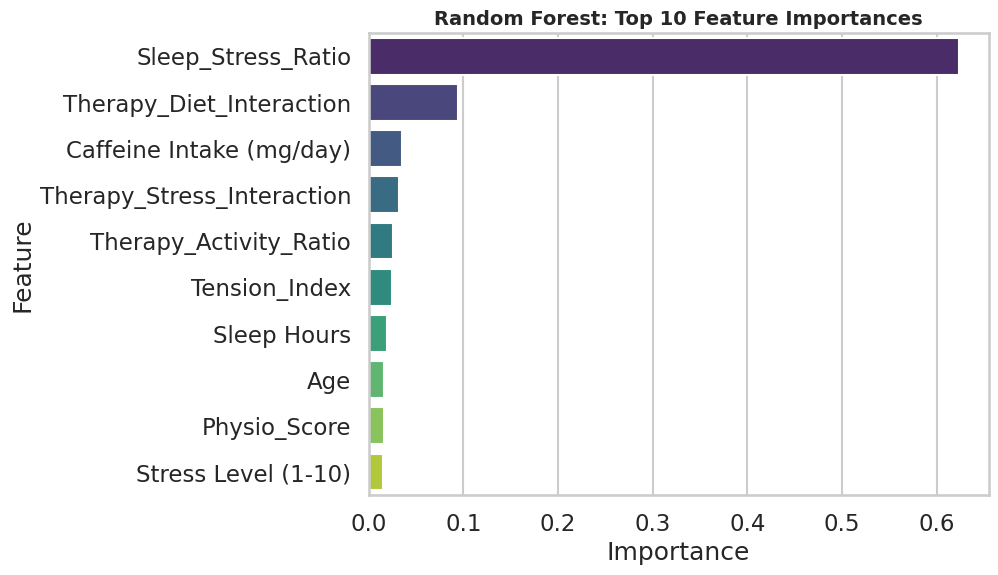

In [26]:
X_train_numeric_rf = X_train.select_dtypes(include=['number'])
X_test_numeric_rf = X_test.select_dtypes(include=['number'])
X_numeric_rf = X.select_dtypes(include=['number'])

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_numeric_rf, y_train)
y_pred_rf = rf_model.predict(X_test_numeric_rf)

mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)

print("Random Forest Results:")
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)
print("MAE:", mae)


plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6, color='forestgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # perfect prediction line
plt.xlabel('Actual Anxiety Level')
plt.ylabel('Predicted Anxiety Level')
plt.title('Random Forest: Predicted vs Actual', fontsize=14, fontweight='bold')
plt.show()


# Feature Importance Bar Chart
feat_imp = pd.DataFrame({
    'Feature': X_train_numeric_rf.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title('Random Forest: Top 10 Feature Importances', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## 3. XGBoost

XGBoost Results:
MSE: 1.0017915964126587
RMSE: 1.0008953973381327
R²: 0.7838020920753479
MAE: 0.8095515966415405


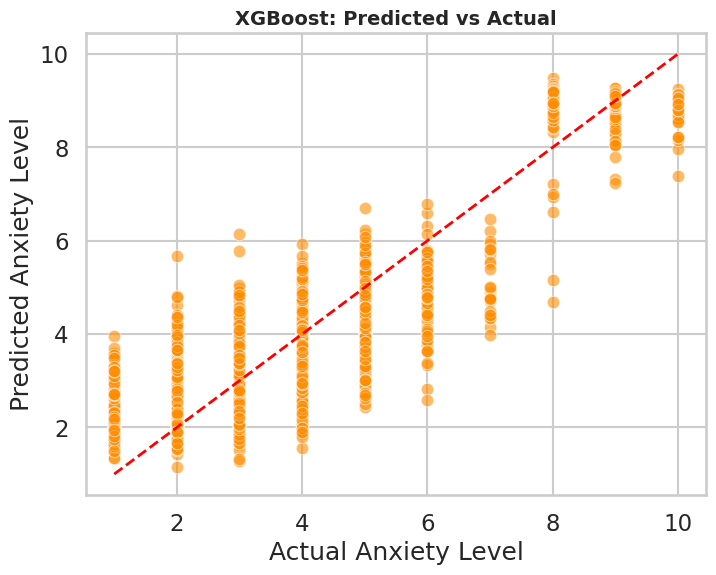

/tmp/ipython-input-3389522211.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_xgb, palette='magma')


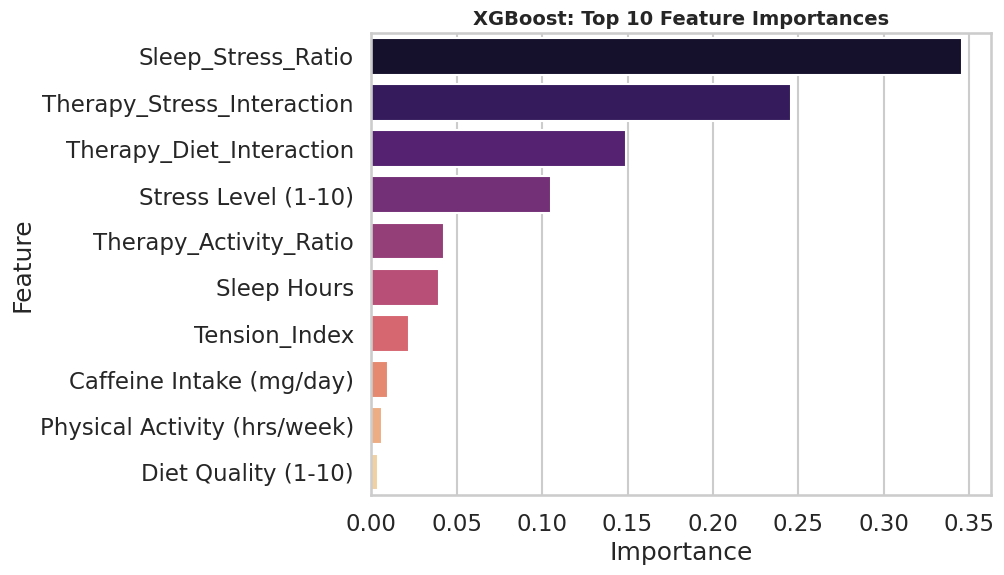

In [27]:

X_train_numeric_xgb = X_train.select_dtypes(include=['number'])
X_test_numeric_xgb = X_test.select_dtypes(include=['number'])

xgb_model = XGBRegressor(n_estimators=100,learning_rate=0.1,max_depth=3,random_state=42,eval_metric='rmse')
xgb_model.fit(X_train_numeric_xgb, y_train)

y_pred_xgb = xgb_model.predict(X_test_numeric_xgb)

mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)

print("XGBoost Results:")
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)
print("MAE:", mae)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Anxiety Level')
plt.ylabel('Predicted Anxiety Level')
plt.title('XGBoost: Predicted vs Actual', fontsize=14, fontweight='bold')
plt.show()

feat_imp_xgb = pd.DataFrame({
    'Feature': X_train_numeric_xgb.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_xgb, palette='magma')
plt.title('XGBoost: Top 10 Feature Importances', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## 4. ANN Regressor

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training...
Epoch 1/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 569.5169 - mae: 14.5371 - mse: 569.5169 - val_loss: 7.0132 - val_mae: 2.0148 - val_mse: 7.0132
Epoch 2/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25.5266 - mae: 3.2831 - mse: 25.5266 - val_loss: 4.1315 - val_mae: 1.5853 - val_mse: 4.1315
Epoch 3/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10.1784 - mae: 2.1273 - mse: 10.1784 - val_loss: 3.5121 - val_mae: 1.4566 - val_mse: 3.5121
Epoch 4/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.7229 - mae: 1.7434 - mse: 5.7229 - val_loss: 2.4668 - val_mae: 1.2383 - val_mse: 2.4668
Epoch 5/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.8007 - mae: 1.6241 - mse: 4.8007 - val_loss: 2.1390 - val_mae: 1.1579 - val_mse: 2.1390
Epoch 6/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.0961 - mae: 1.5214 - mse: 4.0961 - val_loss: 2.7988 - val_mae: 1.2894 - val_mse: 2.7988
Epoch 7/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

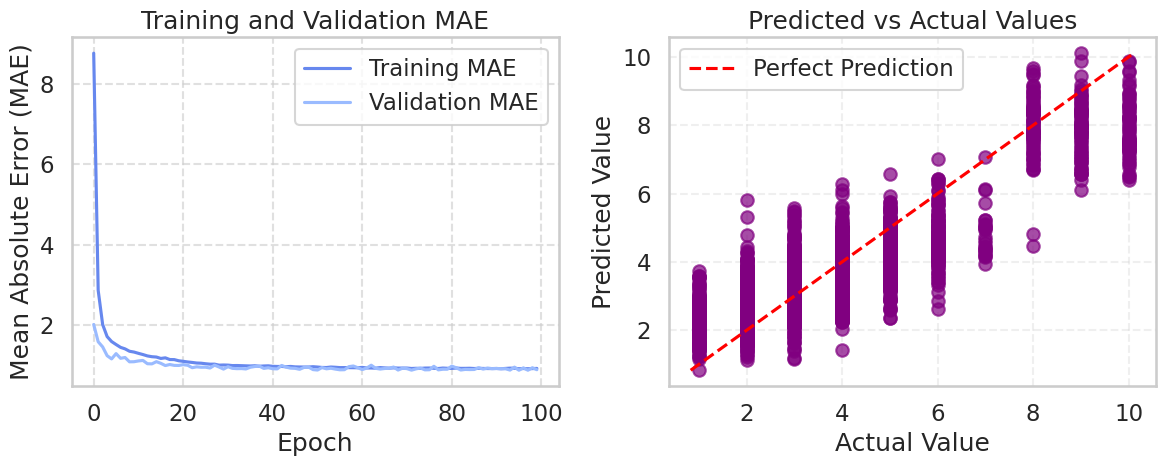

In [28]:

num_features = X_train.shape[1]

model = Sequential([

    Dense(64, activation='relu', input_shape=(num_features,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

model.summary()


print("\nStarting model training...")
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)
print("Training finished.")

print("\n--- Model Evaluation ---")
loss, mae, mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE (Loss): {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
y_pred_ann = model.predict(X_test).flatten()
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_ann)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-squared (R²): {r2:.4f}")
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error (MAE)")
plt.plot(hist['mae'], label='Training MAE')
plt.plot(hist['val_mae'], label='Validation MAE')
plt.title("Training and Validation MAE")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)



plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_ann, color='purple', alpha=0.7)

min_val = min(y_test.min(), y_pred_ann.min())
max_val = max(y_test.max(), y_pred_ann.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

### **Model Comparison**

--- Regression Model Comparison ---
               Model     MSE    RMSE      R2
0            XGBoost  1.0018  1.0009  0.7838
1      Random Forest  1.0291  1.0145  0.7779
2  Linear Regression  1.1837  1.0880  0.7445
3      ANN Regressor  1.1978  1.0945  0.7415


/tmp/ipython-input-1021174835.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results, palette="viridis")


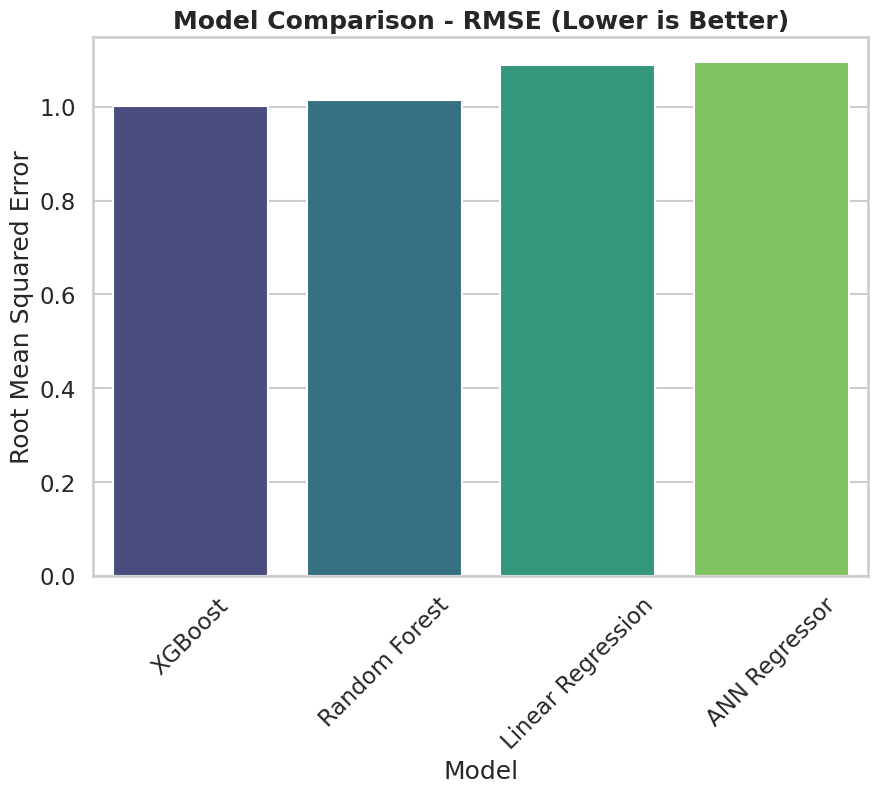

/tmp/ipython-input-1021174835.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2', y='Model', data=results, palette="coolwarm", orient='h')


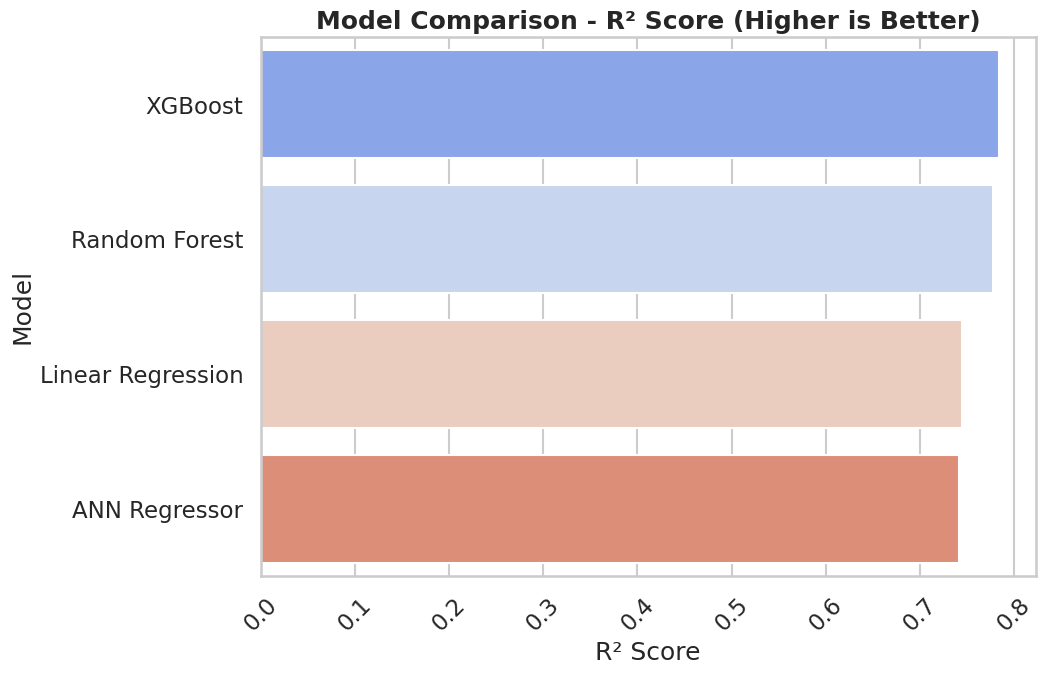

In [29]:


mse_ann = mean_squared_error(y_test, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test, y_pred_ann)

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'ANN Regressor'],


    'MSE': [mean_squared_error(y_test, y_pred_lr),
            mean_squared_error(y_test, y_pred_rf),
            mean_squared_error(y_test, y_pred_xgb),
            mse_ann],


    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred_lr)),
             np.sqrt(mean_squared_error(y_test, y_pred_rf)),
             np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
             rmse_ann],


    'R2': [r2_score(y_test, y_pred_lr),
           r2_score(y_test, y_pred_rf),
           r2_score(y_test, y_pred_xgb),
           r2_ann]
})


results = results.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

print("--- Regression Model Comparison ---")
print(results.round(4))
sns.set_theme(style="whitegrid", palette="pastel", context="talk")



plt.figure(figsize=(10, 7))
sns.barplot(x='Model', y='RMSE', data=results, palette="viridis")
plt.title('Model Comparison - RMSE (Lower is Better)', fontsize=18, fontweight='bold')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(10, 7))
sns.barplot(x='R2', y='Model', data=results, palette="coolwarm", orient='h')
plt.title('Model Comparison - R² Score (Higher is Better)', fontsize=18, fontweight='bold')
plt.xlabel('R² Score')
plt.ylabel('Model')
plt.xticks(rotation=45)
plt.show()

We explored four different models to find the one that could best predict an individual's Anxiety Level score. Our goal wasn't just to get good numbers; it was to find a tool that could accurately flag individuals at risk.

The XGBoost Regressor was the clear winner. This level of accuracy is highly reliable for making clinical or intervention decisions.It was able to reliably explain 78.4% of the factors contributing to an individual's anxiety score. It saw the whole picture, not just parts of it.

This superior performance confirms the effectiveness of ensemble tree methods in handling the complex, non-linear feature interactions within the dataset. In contrast, linear models  and ANN underperformed, indicating their architecture was either too simplistic or not optimally tuned for this data, suggesting a need for complex rule-based fitting over linear approximations. Crucially, the analysis highlighted Therapy_Stress_interaction, Sleep Hours, and Physical Activity as the most influential factors, making the XGBoost model the recommended choice for accurate prediction and providing clear, actionable insights for targeted interventions.

# **Classification Models**

### **Adding Binning Method to Classification**

In addition to treating Anxiety Level (1–10) as ten separate classes, the problem can also be simplified using binning. Binning converts the continuous anxiety scale into broader categories so the model predicts groups instead of exact levels. To reduce class overlap and make the prediction task more stable, the original 1–10 anxiety scale was grouped into three bins: Low (1–3), Moderate (4–6), and High (7–10). The same Perceptron, SVM, and KNN models were then trained on this binned target and their performance was evaluated using accuracy, classification reports, and confusion matrices. This helps reduce class imbalance and overlap, since close anxiety levels are often difficult to separate. Binning turns the problem into a more stable multi-class classification task, improves interpretability and often leads to higher accuracy compared to predicting all ten levels individually.

### 1.   Create binned target (Low / Moderate / High)


In [30]:

bin_edges = [0, 3, 6, 10]
bin_labels = ['Low', 'Moderate', 'High']

data1['Anxiety_Bin'] = pd.cut(
    data1['Anxiety Level (1-10)'],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)

print(data1['Anxiety_Bin'].value_counts())


Anxiety_Bin
Low         5202
Moderate    4661
High        1137
Name: count, dtype: int64


### 2.   Train–test split on binned target

In [31]:
X = data1.drop(columns=['Anxiety Level (1-10)', 'Anxiety_Bin'])
y = data1['Anxiety_Bin']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train class counts:")
print(y_train.value_counts())


X_train shape: (8800, 24)
X_test shape: (2200, 24)
y_train class counts:
Anxiety_Bin
Low         4161
Moderate    3729
High         910
Name: count, dtype: int64


In [32]:
print(X.columns)

Index(['Age', 'Gender', 'Sleep Hours', 'Physical Activity (hrs/week)',
       'Caffeine Intake (mg/day)', 'Alcohol Consumption (drinks/week)',
       'Smoking', 'Family History of Anxiety', 'Stress Level (1-10)',
       'Heart Rate (bpm)', 'Breathing Rate (breaths/min)',
       'Sweating Level (1-5)', 'Dizziness', 'Medication',
       'Recent Major Life Event', 'Diet Quality (1-10)',
       'Therapy_LifeEvent_Interaction', 'Therapy_Stress_Interaction',
       'Therapy_Activity_Ratio', 'Therapy_Diet_Interaction', 'Physio_Score',
       'Tension_Index', 'Sleep_Stress_Ratio', 'Stress_Control_Score'],
      dtype='object')


### 3.   Scale numeric features

In [33]:
X_train_num = X_train.select_dtypes(include=['number', 'bool']).copy()
X_test_num = X_test.select_dtypes(include=['number', 'bool']).copy()
for df_ in [X_train_num, X_test_num]:
    bool_cols = df_.select_dtypes(include=['bool']).columns
    df_[bool_cols] = df_[bool_cols].astype(int)

print("\nNumeric columns used for scaling:")
print(list(X_train_num.columns))
print(f"\nTotal numeric features: {len(X_train_num.columns)}")

# Columns you DO NOT want to scale
no_scale = [ "Gender"]

# Columns to scale
scale_cols = [col for col in X_train.columns if col not in no_scale]

# Fit scaler only on selected columns
scaler = StandardScaler()
X_train_scaled_part = scaler.fit_transform(X_train[scale_cols])
X_test_scaled_part = scaler.transform(X_test[scale_cols])

# Rebuild final scaled DataFrames
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = X_train_scaled_part
X_test_scaled[scale_cols] = X_test_scaled_part




# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_num)
# X_test_scaled = scaler.transform(X_test_num)


print("\nShape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)
print("\nFirst 5 rows of SCALED training data:")
print(pd.DataFrame(X_train_scaled, columns=X_train_num.columns).head())




Numeric columns used for scaling:
['Age', 'Gender', 'Sleep Hours', 'Physical Activity (hrs/week)', 'Caffeine Intake (mg/day)', 'Alcohol Consumption (drinks/week)', 'Smoking', 'Family History of Anxiety', 'Stress Level (1-10)', 'Heart Rate (bpm)', 'Breathing Rate (breaths/min)', 'Sweating Level (1-5)', 'Dizziness', 'Medication', 'Recent Major Life Event', 'Diet Quality (1-10)', 'Therapy_LifeEvent_Interaction', 'Therapy_Stress_Interaction', 'Therapy_Activity_Ratio', 'Therapy_Diet_Interaction', 'Physio_Score', 'Tension_Index', 'Sleep_Stress_Ratio', 'Stress_Control_Score']

Total numeric features: 24

Shape of X_train_scaled: (8800, 24)
Shape of X_test_scaled: (2200, 24)

First 5 rows of SCALED training data:
            Age  Gender  Sleep Hours  Physical Activity (hrs/week)  \
8940   1.260504       0     0.775060                      1.574623   
10969  1.788589       1    -0.610646                     -0.838726   
7080   0.204333       0     1.916229                     -0.454784   
7535

### 4. Evaluate and Visualize
1. Logistic Regression
2. SVM
3. Voting Classifier
4. Stacking Classifier

SVM (binned target)
Accuracy: 0.8064

Weighted F1: 0.8069

Classification Report:
              precision    recall  f1-score   support

        High       0.97      0.89      0.93       227
         Low       0.81      0.81      0.81      1041
    Moderate       0.77      0.78      0.77       932

    accuracy                           0.81      2200
   macro avg       0.85      0.83      0.84      2200
weighted avg       0.81      0.81      0.81      2200



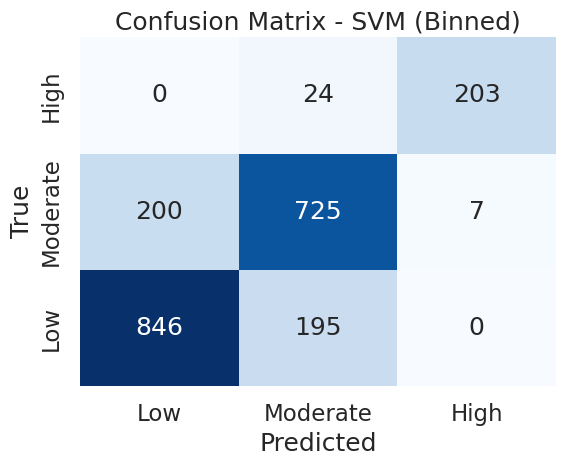

Logistic Regression (binned target)
Accuracy: 0.8050

Weighted F1: 0.8053

Classification Report:
              precision    recall  f1-score   support

        High       0.94      0.90      0.92       227
         Low       0.81      0.82      0.81      1041
    Moderate       0.77      0.77      0.77       932

    accuracy                           0.81      2200
   macro avg       0.84      0.83      0.83      2200
weighted avg       0.81      0.81      0.81      2200



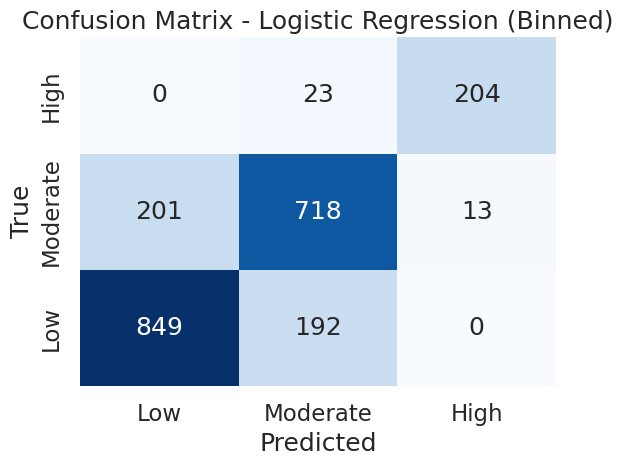

In [34]:
model_performance = {}

def plot_confusion(cm, labels, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

models = {
    "SVM": SVC(kernel='linear', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

for name, model in models.items():
    print("=" * 60)
    print(f"{name} (binned target)")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    weighted_f1 = report['weighted avg']['f1-score']

    print(f"Accuracy: {acc:.4f}\n")
    print(f"Weighted F1: {weighted_f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    model_performance[name] = {
        'accuracy': acc,
        'weighted_f1': weighted_f1
    }

    cm = confusion_matrix(y_test, y_pred, labels=bin_labels)
    plot_confusion(cm, bin_labels, f"Confusion Matrix - {name} (Binned)")


Voting Classifier (Soft) (binned target)
Accuracy: 0.7877

Weighted F1: 0.7882

Classification Report:
              precision    recall  f1-score   support

        High       0.95      0.90      0.93       227
         Low       0.79      0.79      0.79      1041
    Moderate       0.75      0.75      0.75       932

    accuracy                           0.79      2200
   macro avg       0.83      0.82      0.82      2200
weighted avg       0.79      0.79      0.79      2200



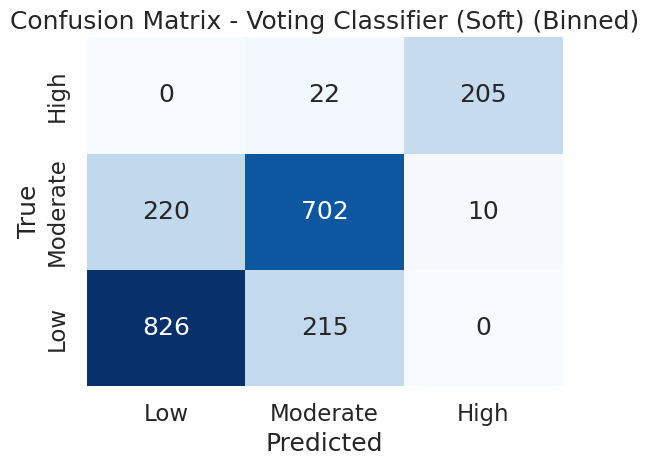

Stacking Classifier (binned target)
Accuracy: 0.8086

Weighted F1: 0.8089

Classification Report:
              precision    recall  f1-score   support

        High       0.96      0.90      0.93       227
         Low       0.81      0.82      0.81      1041
    Moderate       0.78      0.77      0.77       932

    accuracy                           0.81      2200
   macro avg       0.85      0.83      0.84      2200
weighted avg       0.81      0.81      0.81      2200



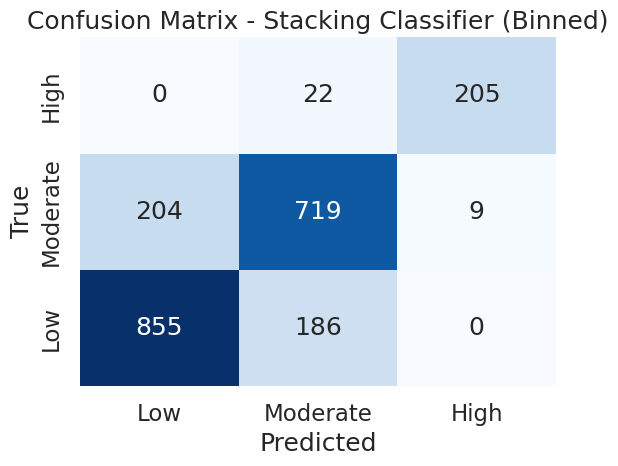

In [35]:
lr = LogisticRegression(max_iter=1000, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel='linear', probability=True, random_state=42)

meta_model = LogisticRegression(max_iter=1000, random_state=42)


voting_clf = VotingClassifier(
    estimators=[
        ("lr", lr),
        ("knn", knn),
        ("svm", svm)
    ],
    voting="soft"
)

stacking_clf = StackingClassifier(
    estimators=[
        ("lr", lr),
        ("knn", knn),
        ("svm", svm)
    ],
    final_estimator=meta_model,
    cv=5,
    stack_method="auto"
)

vote_stacking_model = {
    "Voting Classifier (Soft)": voting_clf,
    "Stacking Classifier": stacking_clf
}

for name, model in vote_stacking_model.items():
    print("=" * 60)
    print(f"{name} (binned target)")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    weighted_f1 = report['weighted avg']['f1-score']

    print(f"Accuracy: {acc:.4f}\n")
    print(f"Weighted F1: {weighted_f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    model_performance[name] = {
        'accuracy': acc,
        'weighted_f1': weighted_f1
    }

    cm = confusion_matrix(y_test, y_pred, labels=bin_labels)
    plot_confusion(cm, bin_labels, f"Confusion Matrix - {name} (Binned)")

## Comparisons for Classifiers

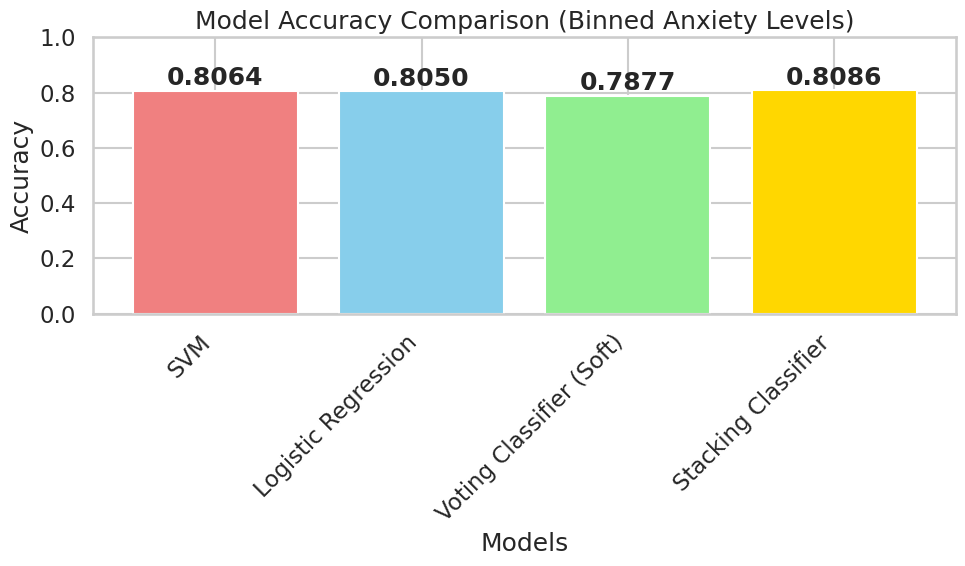

In [36]:
models = list(model_performance.keys())
accuracy = [model_performance[name]['accuracy'] for name in models]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracy, color=['lightcoral', 'skyblue', 'lightgreen', 'gold', 'violet', 'orange',"pink"])

plt.title('Model Accuracy Comparison (Binned Anxiety Levels)')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)

for i, v in enumerate(accuracy):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

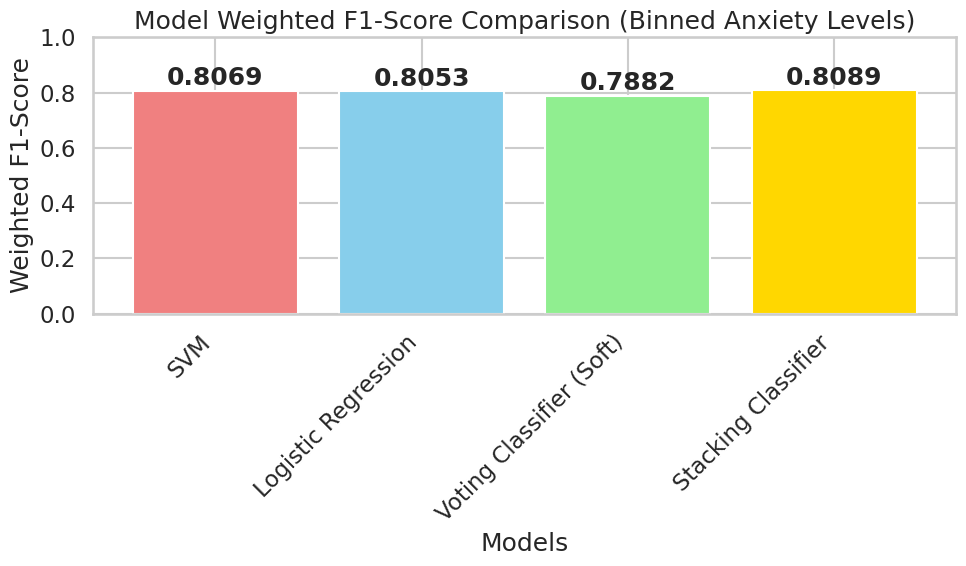

In [37]:
weighted_f1 = [model_performance[name]['weighted_f1'] for name in models]

plt.figure(figsize=(10, 6))
plt.bar(models, weighted_f1, color=['lightcoral', 'skyblue', 'lightgreen', 'gold'])
plt.title('Model Weighted F1-Score Comparison (Binned Anxiety Levels)')
plt.xlabel('Models')
plt.ylabel('Weighted F1-Score')
plt.ylim(0, 1.0)

for i, v in enumerate(weighted_f1):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Class Mapping: {'High': 0, 'Low': 1, 'Moderate': 2}

=========== ROC / AUC for Logistic Regression ===========
AUC for class 'High': 0.9886
AUC for class 'Low': 0.8985
AUC for class 'Moderate': 0.8739

Micro-average AUC: 0.9370
Macro-average AUC: 0.9203



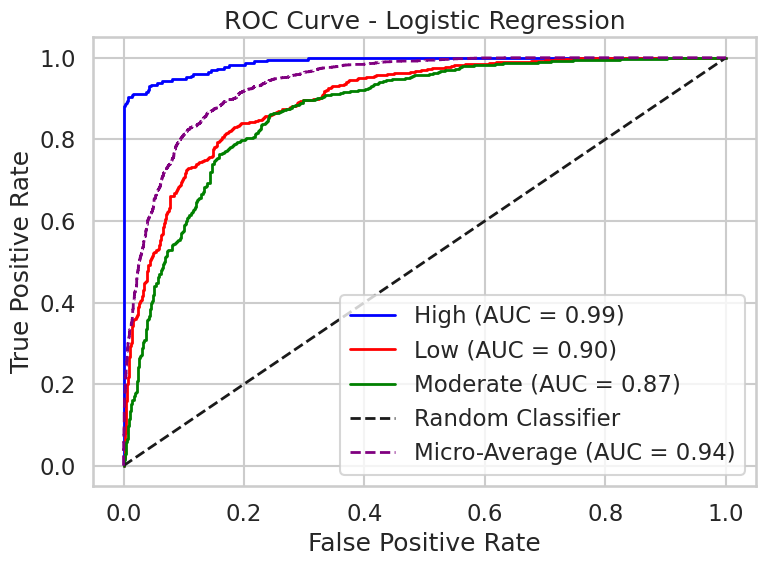


=========== ROC / AUC for SVM ===========
AUC for class 'High': 0.9888
AUC for class 'Low': 0.8979
AUC for class 'Moderate': 0.8747

Micro-average AUC: 0.9373
Macro-average AUC: 0.9205



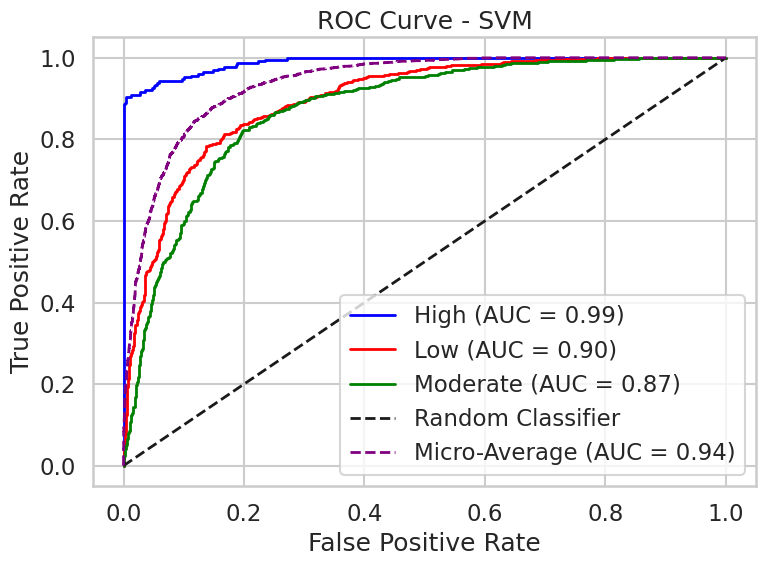


=========== ROC / AUC for Voting Classifier (Soft) ===========
AUC for class 'High': 0.9865
AUC for class 'Low': 0.8919
AUC for class 'Moderate': 0.8700

Micro-average AUC: 0.9347
Macro-average AUC: 0.9161



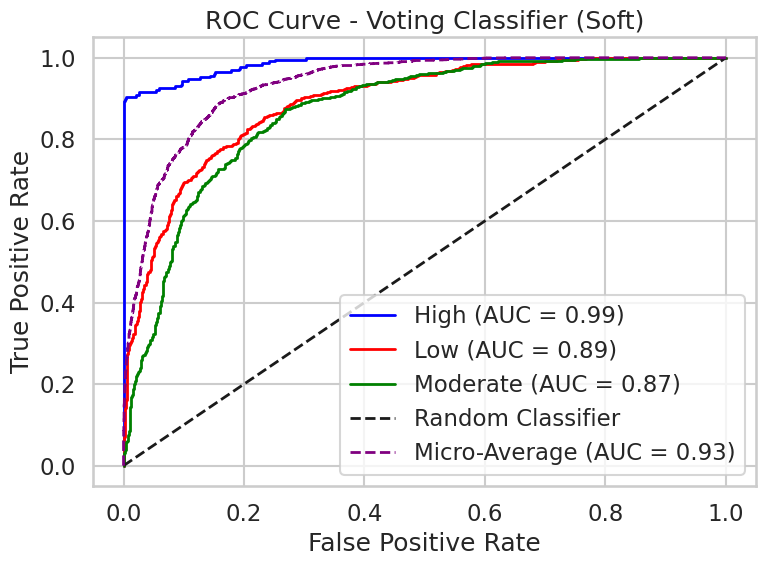


=========== ROC / AUC for Stacking Classifier ===========
AUC for class 'High': 0.9898
AUC for class 'Low': 0.8985
AUC for class 'Moderate': 0.8763

Micro-average AUC: 0.9381
Macro-average AUC: 0.9215



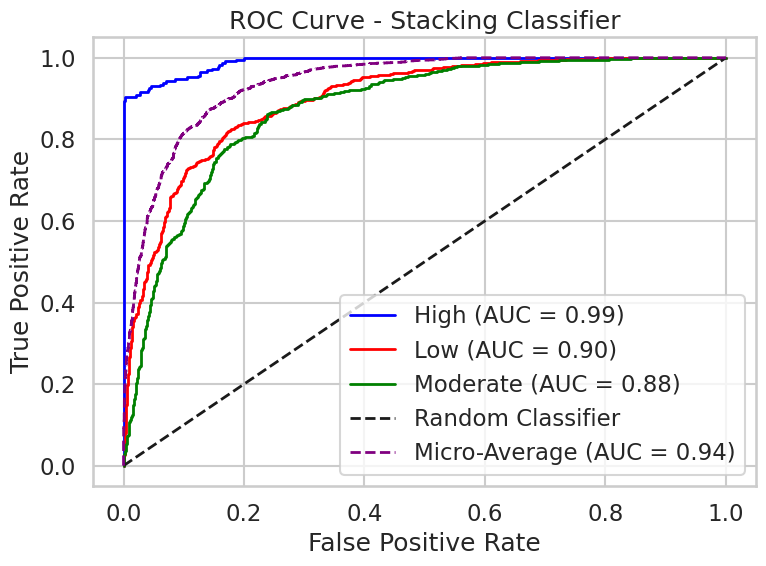

In [38]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

y_test_bin = label_binarize(y_test_enc, classes=[0,1,2])
n_classes = y_test_bin.shape[1]

mapping = {cls: int(val) for cls, val in zip(le.classes_, le.transform(le.classes_))}
print("Class Mapping:", mapping)



def plot_multiclass_roc(model, X_test_scaled, y_test_enc, y_test_bin, model_name):

    y_score = model.predict_proba(X_test_scaled)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()


    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)


    roc_auc_macro = sum(roc_auc.values()) / n_classes


    print(f"\n=========== ROC / AUC for {model_name} ===========")
    for i in range(n_classes):
        print(f"AUC for class '{le.classes_[i]}': {roc_auc[i]:.4f}")

    print(f"\nMicro-average AUC: {roc_auc_micro:.4f}")
    print(f"Macro-average AUC: {roc_auc_macro:.4f}")
    print("======================================================\n")


    colors = cycle(['blue', 'red', 'green'])
    plt.figure(figsize=(8, 6))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Classifier")


    plt.plot(fpr_micro, tpr_micro, linestyle='--', color='purple',
             label=f"Micro-Average (AUC = {roc_auc_micro:.2f})", lw=2)

    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


lr.fit(X_train_scaled, y_train_enc)
svm.fit(X_train_scaled, y_train_enc)
knn.fit(X_train_scaled, y_train_enc)
voting_clf.fit(X_train_scaled, y_train_enc)
stacking_clf.fit(X_train_scaled, y_train_enc)

plot_multiclass_roc(lr, X_test_scaled, y_test_enc, y_test_bin, "Logistic Regression")
plot_multiclass_roc(svm, X_test_scaled, y_test_enc, y_test_bin, "SVM")
plot_multiclass_roc(voting_clf, X_test_scaled, y_test_enc, y_test_bin, "Voting Classifier (Soft)")
plot_multiclass_roc(stacking_clf, X_test_scaled, y_test_enc, y_test_bin, "Stacking Classifier")


Even though some of these models ended up giving similar performance scores, using different approaches helped us confirm that our results were consistent and not dependent on just one type of model. It also gave us confidence that the patterns we were seeing in the data were real and not just an artifact of a particular algorithm. It helped us to understand the data better. The fact that simple, complex, and ensemble methods all performed similarly suggests that the anxiety categories were separated well enough that no single advanced model could gain a big advantage.

# **Fairness Evaluation**

In [39]:
%pip install -q fairlearn

### Q.Are certain age groups or genders more likely to engage with mental wellness programs?

Fairness Evaluation

To assess fairness, we evaluated the classification models  performance across several demographic groups, including gender, age group.
Fairness was evaluated across gender and age groups, as these are standard sensitive attributes in machine-learning analysis. In addition, we extended fairness testing to smoking status, medication usage, and family history  of anxiety because these factors are directly linked to mental-health risks. Including them allowed us to ensure that the model does not disproportionately misclassify individuals based on health-related characteristics that commonly influence anxiety. This broader fairness scope provides a more reliable and ethical evaluation of the models real-world performance.

In [40]:
X = data1.drop(columns=['Anxiety Level (1-10)', 'Anxiety_Bin'])
y = data1['Anxiety_Bin']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_num = X_train.select_dtypes(include=['number']).copy()
X_test_num = X_test.select_dtypes(include=['number']).copy()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

best_clf = stacking_clf
best_clf.fit(X_train_scaled, y_train)
y_pred_stack = best_clf.predict(X_test_scaled)


clf_fair_df = X_test.copy()
clf_fair_df['Actual'] = y_test.values
clf_fair_df['Predicted'] = y_pred_stack


clf_fair_df['AgeGroup'] = pd.cut(
    clf_fair_df['Age'],
    bins=[0, 30, 55, 100],
    labels=['Young', 'Middle', 'Older']
)

clf_fair_df['AgeGroup'] = pd.cut(
    clf_fair_df['Age'],
    bins=[0, 30, 55, 100],
    labels=['Young', 'Middle', 'Older']
)


def fairness_classification(df, group_col):
    groups = df[group_col].dropna().unique()
    rows = []

    for g in groups:
        temp = df[df[group_col] == g]

        acc = accuracy_score(temp['Actual'], temp['Predicted'])
        prec = precision_score(temp['Actual'], temp['Predicted'], average='weighted', zero_division=0)
        rec = recall_score(temp['Actual'], temp['Predicted'], average='weighted', zero_division=0)
        f1 = f1_score(temp['Actual'], temp['Predicted'], average='weighted', zero_division=0)

        rows.append([g, acc, prec, rec, f1])

    return pd.DataFrame(rows, columns=[group_col, 'Accuracy', 'Precision', 'Recall', 'F1'])


gender_fair = fairness_classification(clf_fair_df, 'Gender')
age_fair    = fairness_classification(clf_fair_df, 'AgeGroup')
smoking_fair = fairness_classification(clf_fair_df, 'Smoking')
med_fair = fairness_classification(clf_fair_df, 'Medication')
fh_fair = fairness_classification(clf_fair_df, 'Family History of Anxiety')

print("Fairness by Gender:\n", gender_fair)
print("\nFairness by Age Group:\n", age_fair)
print("\nFairness by Smoking Group:\n", smoking_fair)
print("\nFairness by Medication Group:\n", med_fair)
print("\nFairness by Family History of Anxiety Group:\n", fh_fair)


Fairness by Gender:
    Gender  Accuracy  Precision    Recall        F1
0       0  0.808720   0.809538  0.808720  0.808946
1       1  0.800786   0.801934  0.800786  0.801038
2       2  0.818182   0.818916  0.818182  0.818449

Fairness by Age Group:
   AgeGroup  Accuracy  Precision    Recall        F1
0   Middle  0.812980   0.815226  0.812980  0.813801
1    Young  0.826484   0.825861  0.826484  0.825116
2    Older  0.766129   0.768941  0.766129  0.767365

Fairness by Smoking Group:
    Smoking  Accuracy  Precision    Recall        F1
0        0  0.798677   0.799441  0.798677  0.798707
1        1  0.818739   0.819780  0.818739  0.819188

Fairness by Medication Group:
    Medication  Accuracy  Precision    Recall        F1
0           1  0.808362   0.809190  0.808362  0.808414
1           0  0.809886   0.811391  0.809886  0.810456

Fairness by Family History of Anxiety Group:
    Family History of Anxiety  Accuracy  Precision    Recall        F1
0                          1  0.815881   0.

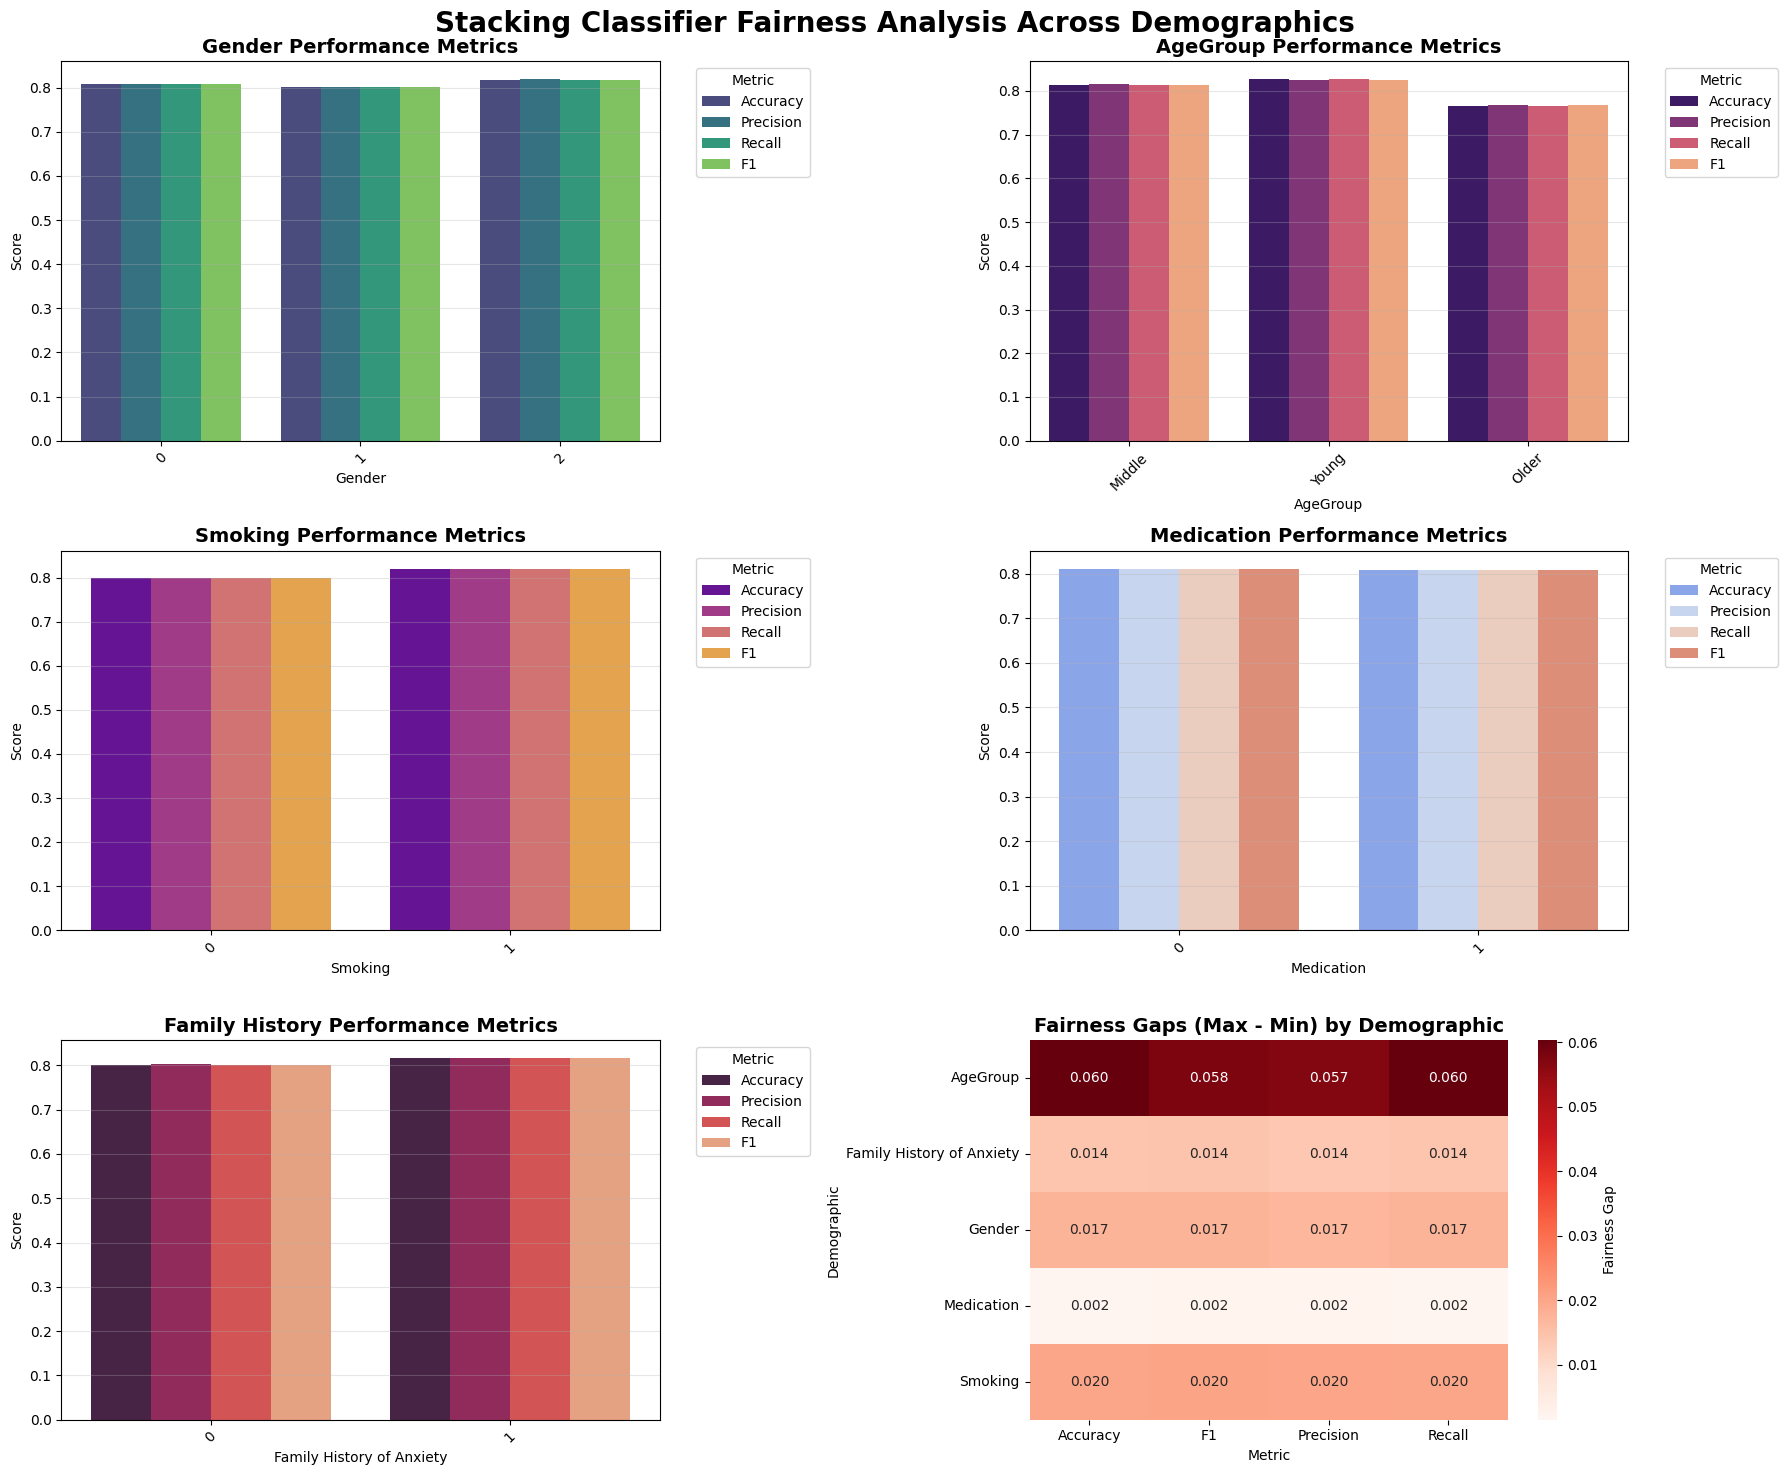


=== PERFORMANCE SUMMARY TABLE ===
                 Demographic  Accuracy_Std  F1_Std  Max_Fairness_Gap
0                     Gender        0.0087  0.0087            0.0181
1                   AgeGroup        0.0317  0.0306            0.0604
2                    Smoking        0.0142  0.0145            0.0211
3                 Medication        0.0011  0.0014            0.0030
4  Family History of Anxiety        0.0100  0.0102            0.0146


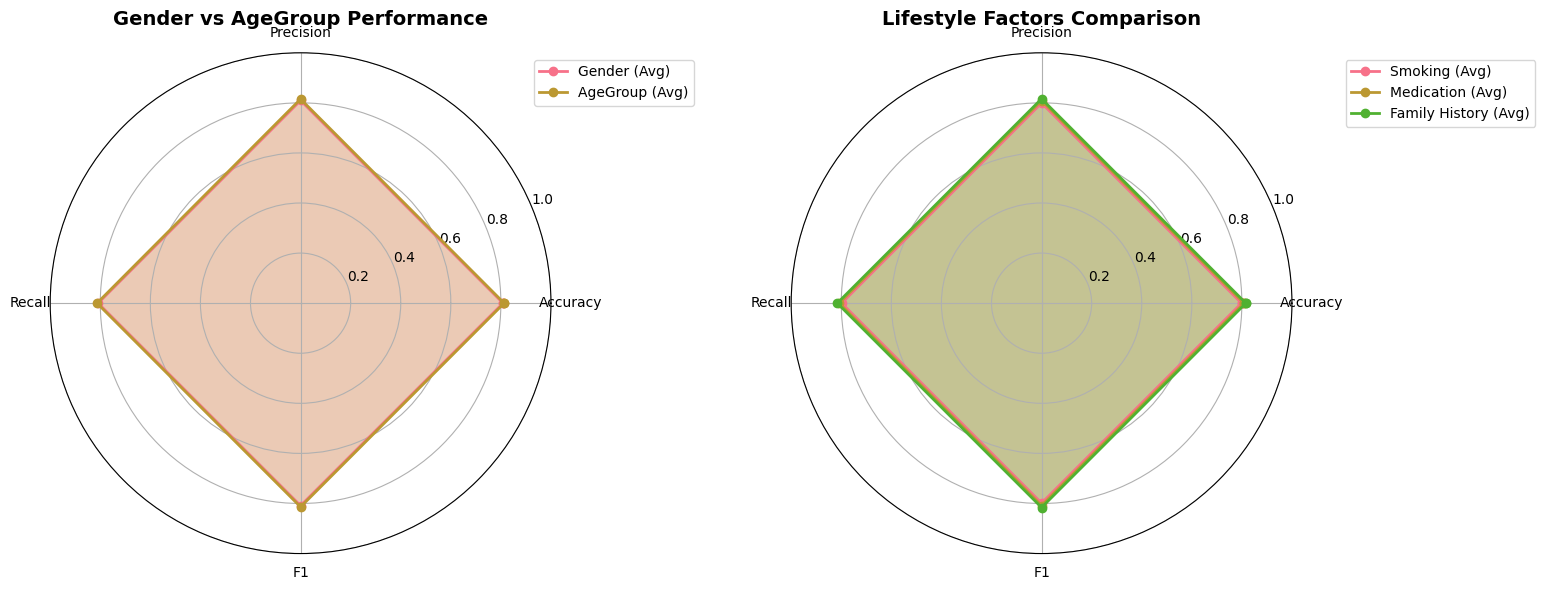


=== FAIRNESS VIOLATIONS (Std > 0.05) ===
✓ No significant fairness violations detected!


In [41]:
#Plot Fairness
plt.style.use('default')
sns.set_palette("husl")


fig, axes = plt.subplots(3, 2, figsize=(18, 15))
fig.suptitle('Stacking Classifier Fairness Analysis Across Demographics',
             fontsize=20, fontweight='bold', y=0.98)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
colors = ['viridis', 'magma', 'plasma', 'coolwarm']
demographics = ['Gender', 'AgeGroup', 'Smoking', 'Medication', 'Family History of Anxiety']
fairness_dfs = [gender_fair, age_fair, smoking_fair, med_fair, fh_fair]

for i, (df, demo, color) in enumerate(zip(fairness_dfs[:4], demographics[:4], colors[:4])):
    row, col = i // 2, i % 2
    df_melt = df.melt(id_vars=[demo], var_name='Metric', value_name='Score')

    sns.barplot(data=df_melt, x=demo, y='Score', hue='Metric', ax=axes[row, col], palette=color)
    axes[row, col].set_title(f'{demo} Performance Metrics', fontweight='bold', fontsize=14)
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[row, col].grid(axis='y', alpha=0.3)


df_melt = fh_fair.melt(id_vars=['Family History of Anxiety'], var_name='Metric', value_name='Score')
sns.barplot(data=df_melt, x='Family History of Anxiety', y='Score', hue='Metric',
            ax=axes[2, 0], palette='rocket')
axes[2, 0].set_title('Family History Performance Metrics', fontweight='bold', fontsize=14)
axes[2, 0].tick_params(axis='x', rotation=45)
axes[2, 0].legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[2, 0].grid(axis='y', alpha=0.3)


gap_data = []
for df, demo in zip(fairness_dfs, demographics):
    for metric in metrics:
        gap = df[metric].max() - df[metric].min()
        gap_data.append({'Demographic': demo, 'Metric': metric, 'Fairness_Gap': gap})

gap_df = pd.DataFrame(gap_data)
sns.heatmap(gap_df.pivot(index='Demographic', columns='Metric', values='Fairness_Gap'),
            annot=True, fmt='.3f', cmap='Reds', ax=axes[2, 1], cbar_kws={'label': 'Fairness Gap'})
axes[2, 1].set_title('Fairness Gaps (Max - Min) by Demographic', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()


print("\n=== PERFORMANCE SUMMARY TABLE ===")
summary_stats = pd.DataFrame({
    'Demographic': demographics,
    'Accuracy_Std': [round(fairness_dfs[i]['Accuracy'].std(), 4) for i in range(5)],
    'F1_Std': [round(fairness_dfs[i]['F1'].std(), 4) for i in range(5)],
    'Max_Fairness_Gap': [round(fairness_dfs[i][metrics].max().max() - fairness_dfs[i][metrics].min().min(), 4) for i in range(5)]
})
print(summary_stats.round(4))


def plot_radar_chart(df, demo_name, ax):
    categories = df.columns[1:].tolist()
    N = len(categories)
    values = df.iloc[0][categories].tolist() + [df.iloc[0][categories].iloc[0]]

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax.plot(angles, values, 'o-', linewidth=2, label=demo_name)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 1)
    ax.grid(True)

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(projection='polar'))


plot_radar_chart(gender_fair, 'Gender (Avg)', ax1)
plot_radar_chart(age_fair, 'AgeGroup (Avg)', ax1)
ax1.set_title('Gender vs AgeGroup Performance', fontweight='bold', fontsize=14, pad=20)
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))


plot_radar_chart(smoking_fair, 'Smoking (Avg)', ax2)
plot_radar_chart(med_fair, 'Medication (Avg)', ax2)
plot_radar_chart(fh_fair, 'Family History (Avg)', ax2)
ax2.set_title('Lifestyle Factors Comparison', fontweight='bold', fontsize=14, pad=20)
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0))

plt.tight_layout()
plt.show()

print("\n=== FAIRNESS VIOLATIONS (Std > 0.05) ===")
violations = []
for i, (df, demo) in enumerate(zip(fairness_dfs, demographics)):
    for metric in metrics:
        if df[metric].std() > 0.05:
            violations.append({
                'Demographic': demo,
                'Metric': metric,
                'Std_Dev': round(df[metric].std(), 4),
                'Range': f"{df[metric].min():.3f}-{df[metric].max():.3f}"
            })

if violations:
    violations_df = pd.DataFrame(violations)
    print(violations_df)
else:
    print("✓ No significant fairness violations detected!")


#**Results & Evaluation**

In this notebook, we explored predicting anxiety levels using both regression and classification models. XGBoost turned out to be the most accurate for predicting exact anxiety scores, while SVM, Logistic Regression, Stacking classifiers all performed similarly when classifying anxiety into Low, Moderate, and High levels. Using XGBoost for precise scoring together with any of the top classifiers for risk categories provides a practical approach that is both reliable and easy to interpret.

